# **💼 Capstone Project: Predicting Developer Salaries Using Stack Overflow Survey Data (2023–2024)**

---

## **🧠 Business Understanding**

### 🎯 Project Objective
Build a machine learning model that predicts annual developer salaries using demographic, professional, and technical features. We leverage Stack Overflow’s 2023 and 2024 survey datasets to inform both global and localized (Kenyan) compensation insights.

### ❓ Why This Matters
Salary transparency is limited in many global regions — especially across Africa. Developers often navigate job transitions, promotions, or freelance pricing without reliable benchmarks. This model aims to provide data-driven insights that help both job seekers and hiring managers make informed compensation decisions.

This model helps:
- Developers **benchmark expected compensation**
- Employers **set fair, competitive pay**
- Career changers **evaluate the ROI of learning paths**
- HR platforms **integrate salary prediction engines**
- Policymakers and analysts **understand wage trends in tech**

### 🌍 Kenya-Specific Relevance
In Kenya, tech hubs like Nairobi are booming — yet salary data remains fragmented. This model could:
- Help junior/mid-level developers negotiate better
- Empower remote-first hiring with global salary range visibility
- Be integrated into job platforms like **Fuzu**, **BrighterMonday**, or **Andela**

### 🧑‍💻 Industry Domains
- **Primary**: Technology
- **Secondary**: Human Capital Analytics, Labor Market Research

### 👥 Stakeholders

| Stakeholder Group         | Value Proposition                                                                 |
|---------------------------|------------------------------------------------------------------------------------|
| Developers                | Benchmark realistic compensation based on skills and experience                   |
| Employers & Recruiters    | Offer data-driven, competitive salaries                                            |
| HR Tech Platforms         | Integrate model into job boards or career guidance tools                          |
| Bootcamps & Career Coaches| Showcase expected returns on upskilling efforts                                   |
| Policy & Advocacy Groups  | Inform labor market planning and economic inclusion initiatives                   |

### 🔬 Literature & Prior Work
This project builds on:
- Previous Stack Overflow Salary Calculators (now deprecated)
- ML-based salary models using Random Forest, XGBoost, etc.
- Global developer reports (GitHub Octoverse, Dev.to, HackerRank)

### ✨ Unique Contribution
- Combines recent **multi-year (2023 & 2024)** datasets
- Applies **localized lens** for Kenya/Africa
- Prioritizes **real-world use cases** for talent, HR, and learning ecosystems

### 🎯 Success Metrics
- Overall RMSE: < 0.45 (log scale)
- R² Score: > 0.6
- Validation: Use 20% holdout set and 5-fold stratified CV, validated against salary ranges from local job boards.

### ✅ Validation Approach
- Reserve 20% of data as a holdout set for final evaluation.
- Use stratified 5-fold CV.
- Cross-check predictions.

---

## **📊 Data Understanding**

### 📁 Data Sources
- `survey_results_public_2023.csv`
- `survey_results_public_2024.csv`

Source: [Stack Overflow Developer Survey](https://insights.stackoverflow.com/survey)

### 📐 Data Summary

| Year | Total Responses | Countries | SSA Responses | Kenya Responses |
|------|------------------|-----------|----------------|------------------|
| 2023 | ~89,000          | ~180      | 1,828          | 244              |
| 2024 | ~65,000          | ~188      | 1,271          | 180              |

Combined, we expect **100,000+ usable rows** across ~188 countries.

### 🔑 Key Features

| Category        | Variables (examples)                                                  |
|----------------|------------------------------------------------------------------------|
| Demographics    | `Age`, `Country`, `Gender`                                             |
| Education       | `EdLevel`, `LearnCode`, `YearsCodePro`                                 |
| Employment      | `Employment`, `OrgSize`, `RemoteWork`                                  |
| Technical Tools | `LanguageHaveWorkedWith`, `PlatformHaveWorkedWith`, `AISelect`         |
| Target Variable | `ConvertedCompYearly` (Annual salary in USD)                           |
| Meta Info       | `SurveyYear`, `Currency`                                               |

### ⚠️ Data Limitations & Mitigation Strategies

| Limitation                             | Proposed Mitigation                                           |
|----------------------------------------|---------------------------------------------------------------|
| Schema changes between years           | Focus on **common columns**; map others as needed             |
| Imbalanced country distribution        | Consider **oversampling**, stratified models                  |
| Salary skew and outliers               | Apply **log transformation**, drop outliers via IQR/z-score   |
| Sparse Kenya data                      | Enrich with African subset or train global model              |
| Missing values                         | Drop, impute, or bin categories during preprocessing          |

### 💾 Planned Enhancements
- Add `SurveyYear` column to track year-based differences
- Combine datasets using common schema

---

In [1]:
# Import relevant libraries
# warnings
import warnings
warnings.filterwarnings('ignore')
# data handling
import pandas as pd 
import numpy as np
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# explainability
import shap
# utilities
import os
from pathlib import Path
# feature selection and importance
from sklearn.feature_selection import SelectKBest, f_regression

### 1. Load 2023 & 2024 Stack Overflow Survey Data

In [2]:
# loading the 2023 and 2024 datasets
df_2023 = pd.read_csv('survey_results_public_2023.csv')
df_2024 = pd.read_csv('survey_results_public_2024.csv')


### 2. Understand Schema Differences Between the Two Years

In [3]:

print(df_2023.columns.difference(df_2024.columns))
print(df_2024.columns.difference(df_2023.columns))

Index(['AIDevHaveWorkedWith', 'AIDevWantToWorkWith',
       'AINextNeither different nor similar', 'AINextSomewhat different',
       'AINextSomewhat similar', 'AINextVery different', 'AINextVery similar',
       'AISearchHaveWorkedWith', 'AISearchWantToWorkWith',
       'LearnCodeCoursesCert', 'Q120', 'SOAI', 'TechList'],
      dtype='object')
Index(['AIChallenges', 'AIComplex', 'AIEthics', 'AINextLess integrated',
       'AINextMore integrated', 'AINextMuch less integrated',
       'AINextMuch more integrated', 'AINextNo change', 'AISearchDevAdmired',
       'AISearchDevHaveWorkedWith', 'AISearchDevWantToWorkWith', 'AIThreat',
       'BuildvsBuy', 'Check', 'DatabaseAdmired', 'EmbeddedAdmired',
       'EmbeddedHaveWorkedWith', 'EmbeddedWantToWorkWith', 'Frustration',
       'JobSat', 'JobSatPoints_1', 'JobSatPoints_10', 'JobSatPoints_11',
       'JobSatPoints_4', 'JobSatPoints_5', 'JobSatPoints_6', 'JobSatPoints_7',
       'JobSatPoints_8', 'JobSatPoints_9', 'Knowledge_9', 'LanguageAd

Stack Overflow's survey questions vary slightly each year. We checked for columns that appear in one year but not the other. This helps us align the two datasets before combining them.

In [4]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [5]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


### 3. Merge Datasets for a Unified View

In [6]:
# Add SurveyYear column to distinguish entries
df_2023['SurveyYear'] = 2023
df_2024['SurveyYear'] = 2024

# Align column structure by filling in missing columns in each dataset
missing_2023 = df_2024.columns.difference(df_2023.columns)
missing_2024 = df_2023.columns.difference(df_2024.columns)

# Add missing columns to each dataframe and fill with NaN
for col in missing_2023:
    df_2023[col] = np.nan

for col in missing_2024:
    df_2024[col] = np.nan

# Reorder columns to match, important for concat
df_2023 = df_2023[df_2024.columns]

# Concatenate
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

print(f"Merged shape: {df_all.shape}")


Merged shape: (154621, 128)


We combined the 2023 and 2024 survey responses into one large dataset. To make this possible, we added any missing questions from one year into the other using empty values (NaNs).

## **Data Preprocessing**

## **Exploratory Data Analysis**

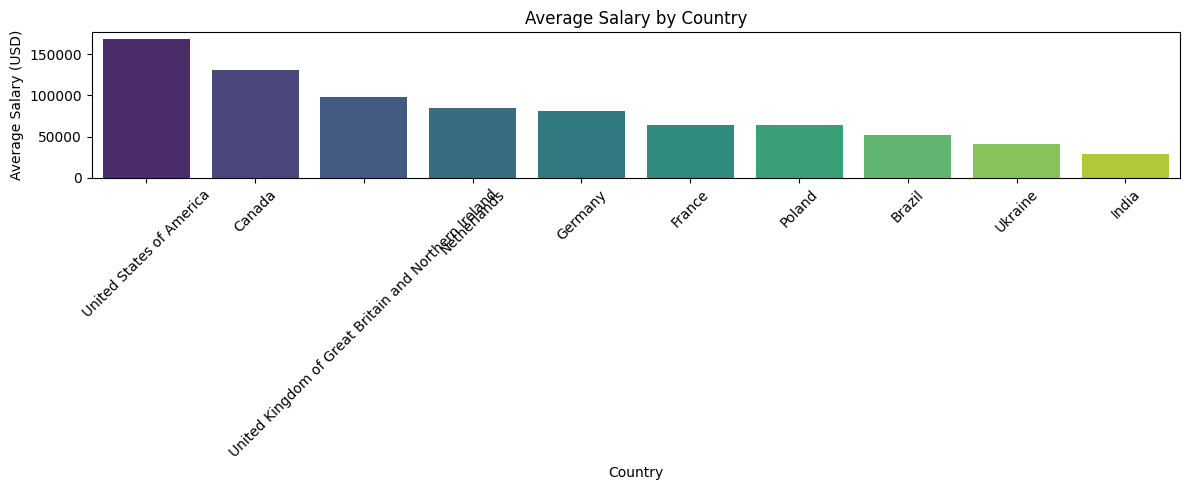

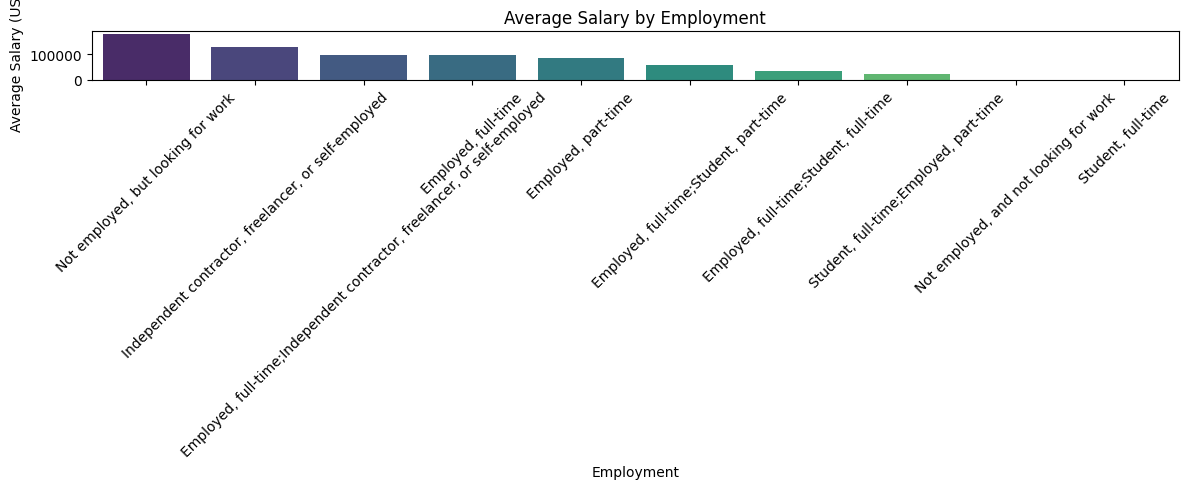

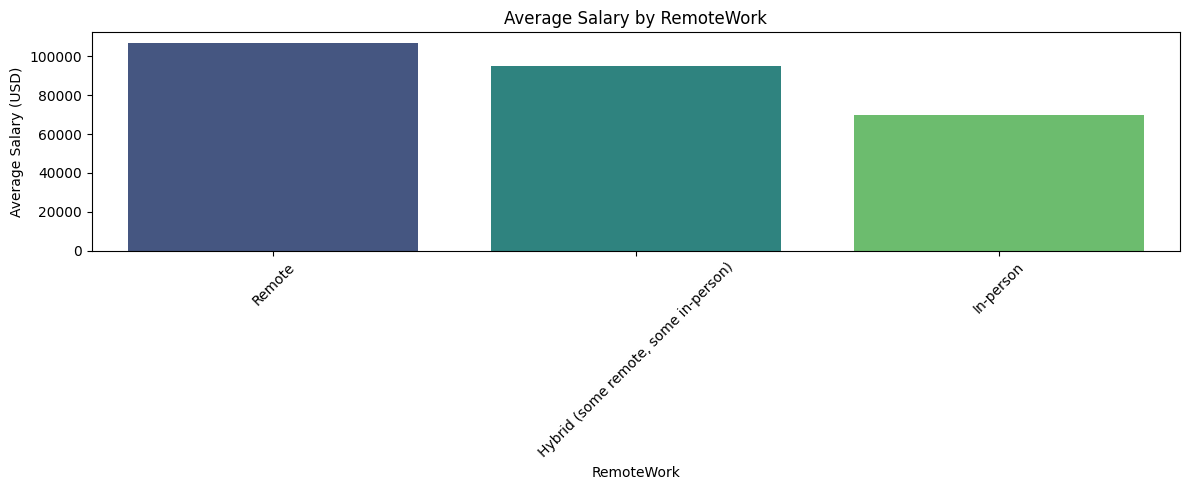

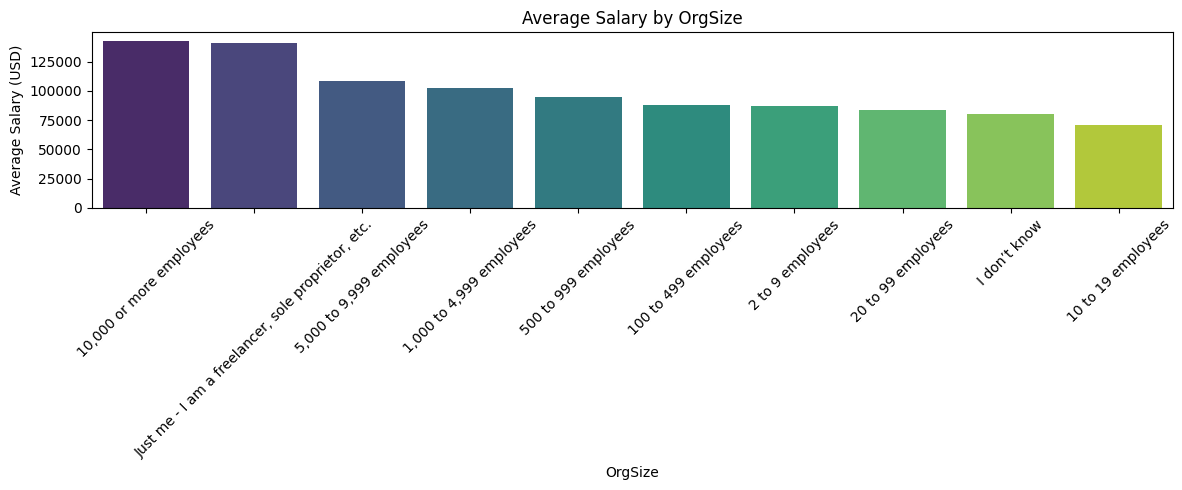

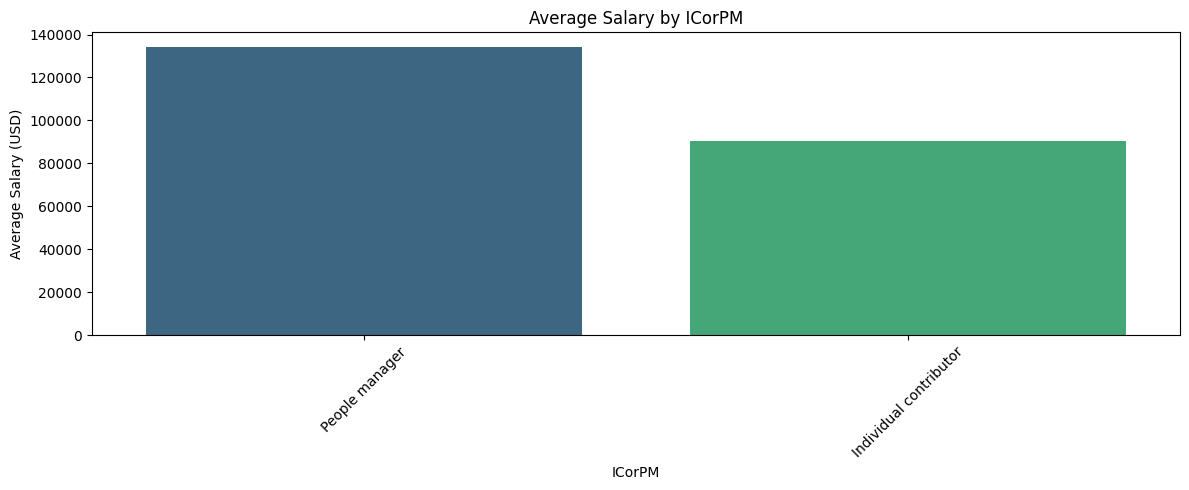

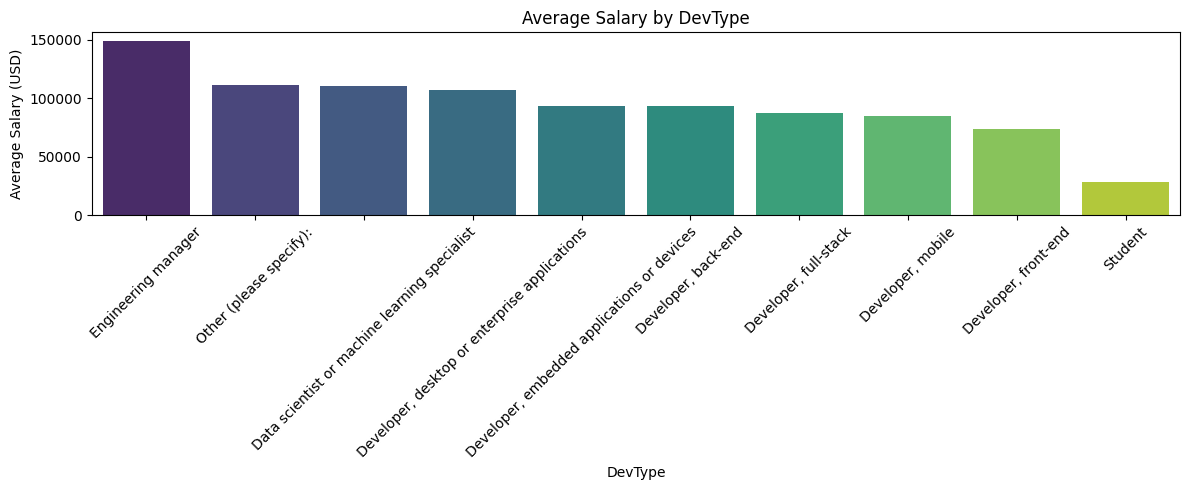

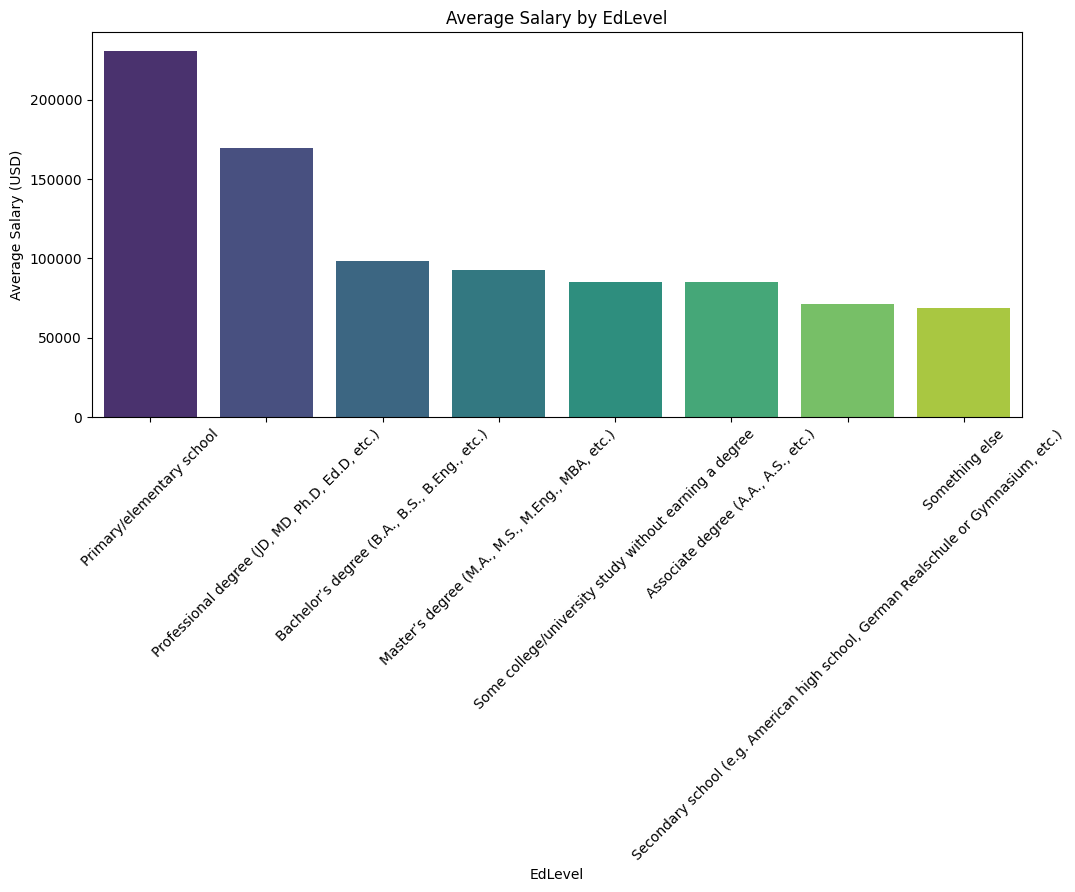

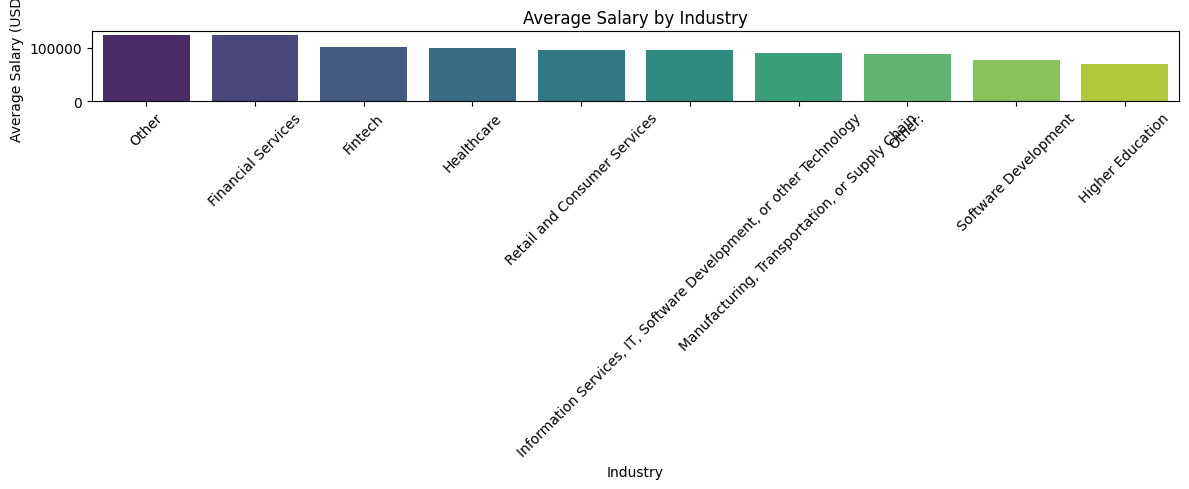

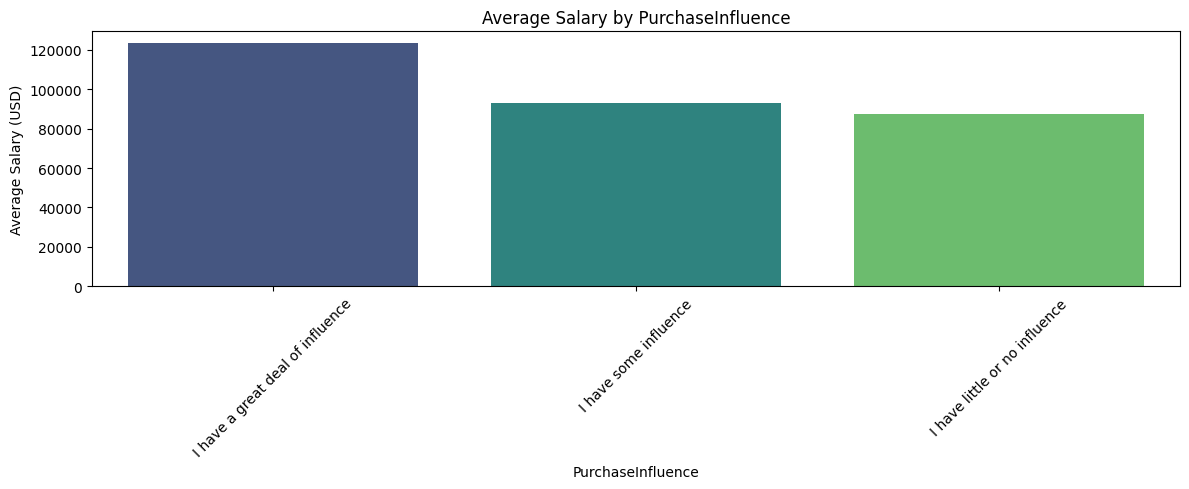

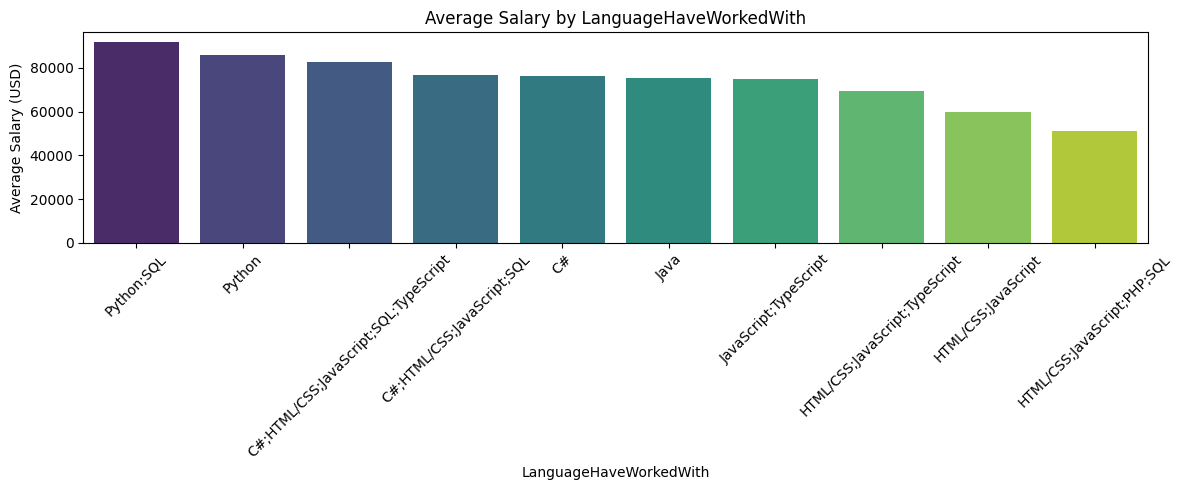

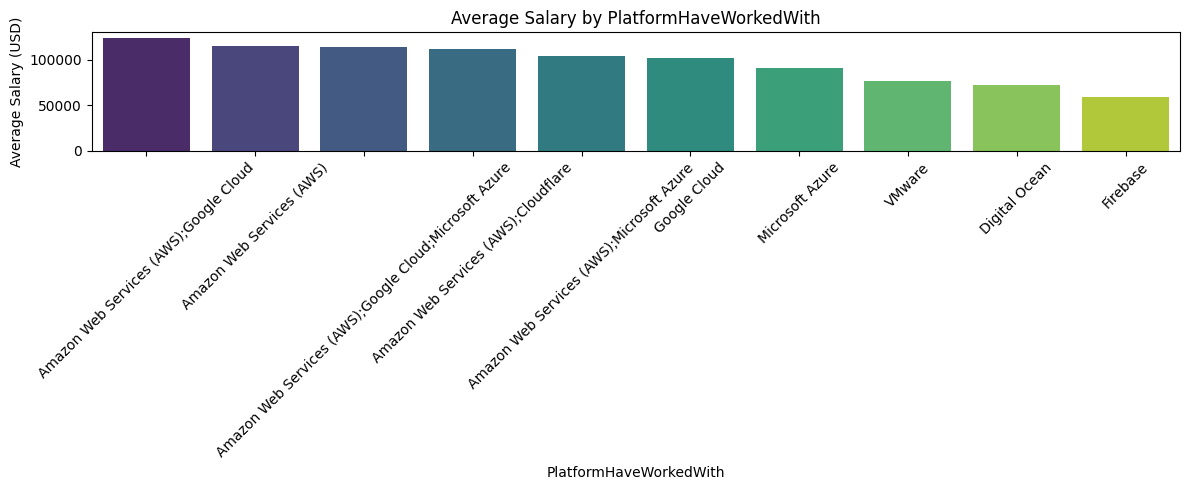

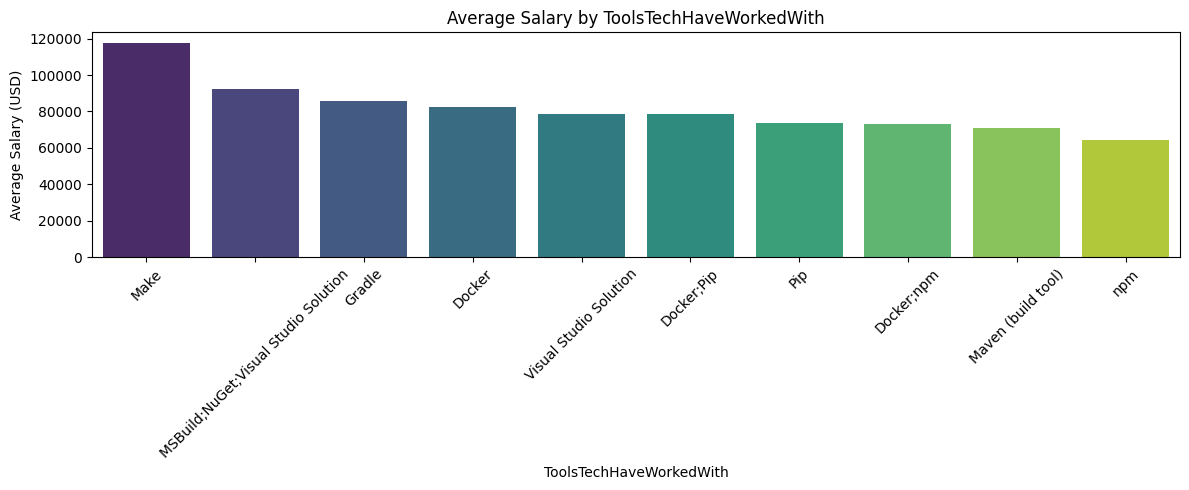

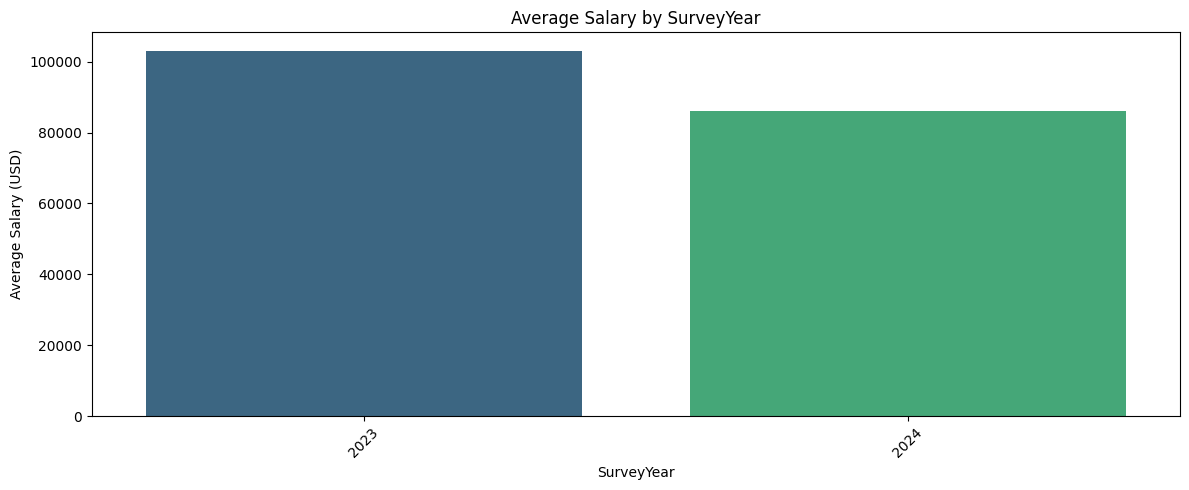

In [7]:


# List of categorical features to analyze
categorical_features = ['Country', 'Employment', 'RemoteWork', 'OrgSize', 'ICorPM', 
                        'DevType', 'EdLevel', 'Industry', 'PurchaseInfluence',
                        'LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 
                        'ToolsTechHaveWorkedWith', 'SurveyYear']

# Loop through each feature and plot the top categories
for feature in categorical_features:
    plt.figure(figsize=(12,5))

    # Filter out 'Missing' values first
    df_filtered = df_all[df_all[feature] != 'Missing']

    # Get top categories by frequency
    top_categories = df_filtered[feature].value_counts().nlargest(10).index

    # Filter to top categories
    filtered_df = df_filtered[df_filtered[feature].isin(top_categories)]

    # Compute mean salary per category, sorted by salary
    sorted_order = (
        filtered_df.groupby(feature)['ConvertedCompYearly']
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # Create barplot
    sns.barplot(
        data=filtered_df,
        x=feature,
        y='ConvertedCompYearly',
        estimator=np.mean,
        ci=None,
        order=sorted_order,
        palette='viridis'
    )

    plt.title(f'Average Salary by {feature}')
    plt.xticks(rotation=45)
    plt.ylabel('Average Salary (USD)')
    plt.tight_layout()
    plt.show()


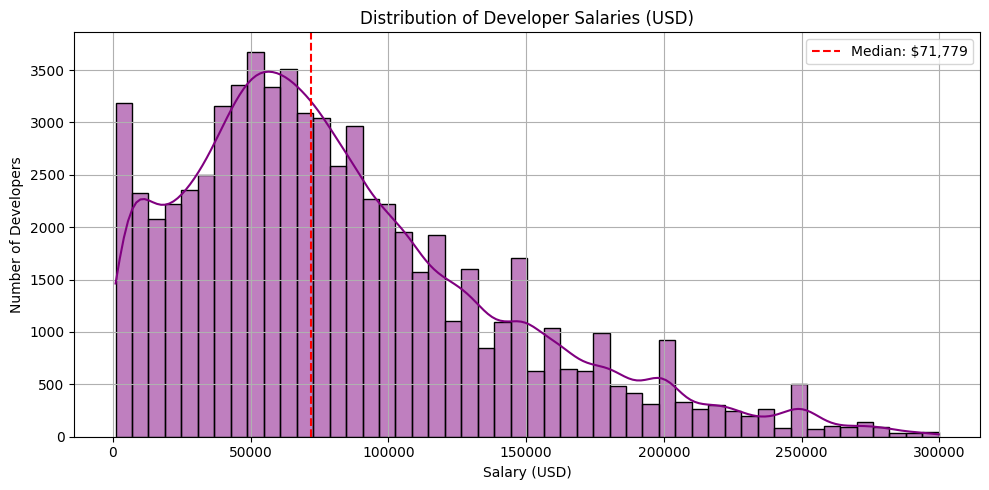

In [8]:
# Clean data
clean_salary = df_all['ConvertedCompYearly'].dropna()
clean_salary = clean_salary[clean_salary > 1000]  # Remove very low outliers
clean_salary = clean_salary[clean_salary < 300000]  # Cap extreme values

# Plot
plt.figure(figsize=(10,5))
sns.histplot(clean_salary, bins=50, kde=True, color='purple')
plt.axvline(clean_salary.median(), color='red', linestyle='--', label=f"Median: ${int(clean_salary.median()):,}")
plt.title("Distribution of Developer Salaries (USD)")
plt.xlabel("Salary (USD)")
plt.ylabel("Number of Developers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ✍️ Interpretation  
Salaries tend to cluster between $30,000 and $100,000 per year, with a few very high earners pulling the average upward. This is known as a right-skewed distribution, most developers earn within a moderate range, while a few outliers earn significantly more.   
**Consider applying log transformation during modeling.**

In [9]:
# Define relevant features for salary prediction (features selected using relevance and domain intuition)
selected_features = [
    'Country', 'Employment', 'RemoteWork', 'OrgSize', 'ICorPM',
    'YearsCodePro', 'DevType', 'EdLevel', 'Industry', 
    'PurchaseInfluence', 'LanguageHaveWorkedWith', 'PlatformHaveWorkedWith',
    'ToolsTechHaveWorkedWith', 'ConvertedCompYearly', 'SurveyYear', 'AIThreat'
]

# Subset and copy data
df = df_all[selected_features].copy()

# Drop missing or unrealistic target values
df = df[df['ConvertedCompYearly'].notna()]
df = df[df['ConvertedCompYearly'] > 1000]  # Filter extremely low salaries

# Handle missing categorical values
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna('Missing')

# Clean numeric features
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
df['YearsCodePro'] = df['YearsCodePro'].fillna(df['YearsCodePro'].median())

print(f"✅ Final Cleaned Data Shape: {df.shape}")


✅ Final Cleaned Data Shape: (70215, 16)


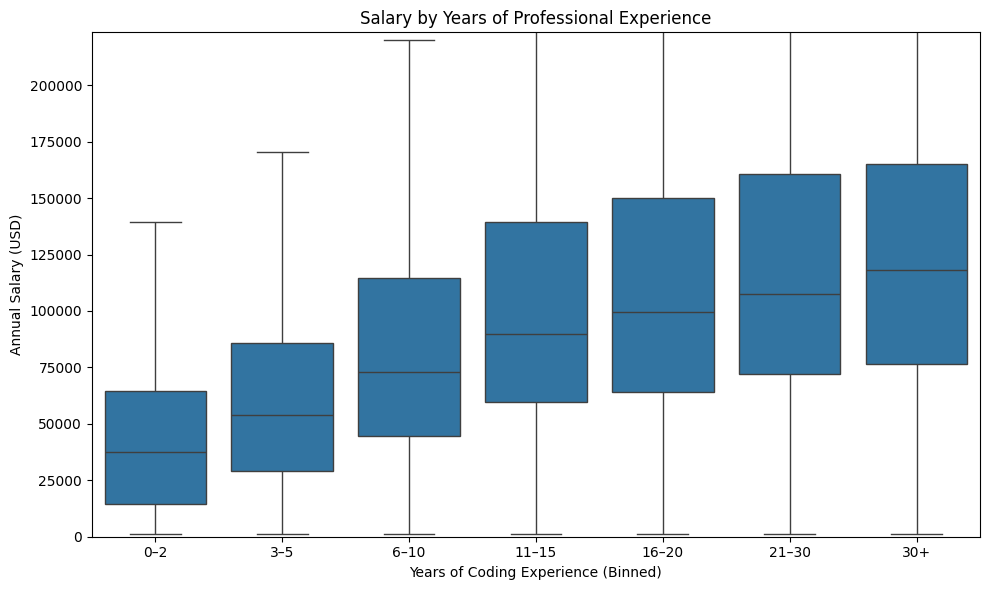

In [10]:
## Salary by years of professional experience
# Filter: Remove missing or unrealistic salary/experience
salary_exp_df = df[
    df['ConvertedCompYearly'].notna() & 
    df['YearsCodePro'].notna()
].copy()

# Bin YearsCodePro for clarity
salary_exp_df['ExperienceBin'] = pd.cut(
    salary_exp_df['YearsCodePro'],
    bins=[0, 2, 5, 10, 15, 20, 30, 50],
    labels=['0–2', '3–5', '6–10', '11–15', '16–20', '21–30', '30+']
)

# Plot
plt.figure(figsize=(10,6))
sns.boxplot(data=salary_exp_df, x='ExperienceBin', y='ConvertedCompYearly', showfliers=False)
plt.title('Salary by Years of Professional Experience')
plt.xlabel('Years of Coding Experience (Binned)')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, salary_exp_df['ConvertedCompYearly'].quantile(0.95))  # Remove extreme outliers
plt.tight_layout()
plt.show()


The graph shows a clear positive correlation between years of professional experience and annual salary. 
As experience increases, salaries tend to rise steadily.  
Diminishing returns observed after 20+ years.



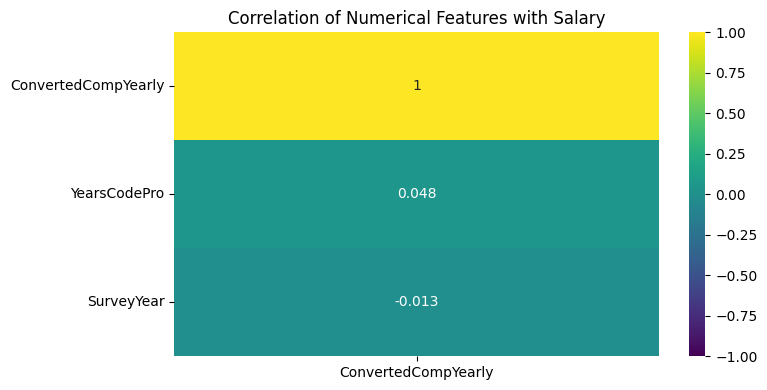

In [11]:
numeric_features = df.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()

plt.figure(figsize=(8,4))
sns.heatmap(
    corr_matrix[['ConvertedCompYearly']].sort_values(by='ConvertedCompYearly', ascending=False),
    annot=True, cmap='viridis', vmin=-1, vmax=1
)
plt.title("Correlation of Numerical Features with Salary")
plt.tight_layout()
plt.show()


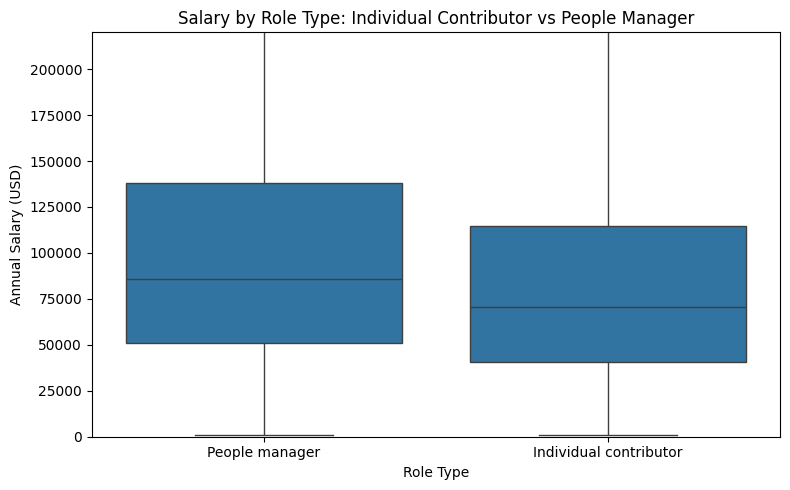

In [12]:
## Salary by ICorPM (Individual Contributor vs People Manager)
# Filter to remove missing or "Missing" values
ic_pm_df = df[
    df['ConvertedCompYearly'].notna() &
    df['ICorPM'].notna() &
    (df['ICorPM'] != 'Missing')
].copy()

# Plot salary distribution by ICorPM
plt.figure(figsize=(8,5))
sns.boxplot(
    data=ic_pm_df,
    x='ICorPM',
    y='ConvertedCompYearly',
    showfliers=False  # hides extreme outliers
)

plt.title('Salary by Role Type: Individual Contributor vs People Manager')
plt.xlabel('Role Type')
plt.ylabel('Annual Salary (USD)')
plt.ylim(0, ic_pm_df['ConvertedCompYearly'].quantile(0.95))  # limit y-axis to 95th percentile
plt.tight_layout()
plt.show()


The average annual salary for a People Manager role is significantly higher than the average salary for an Individual Contributor role. The graph shows a clear gap between the two.

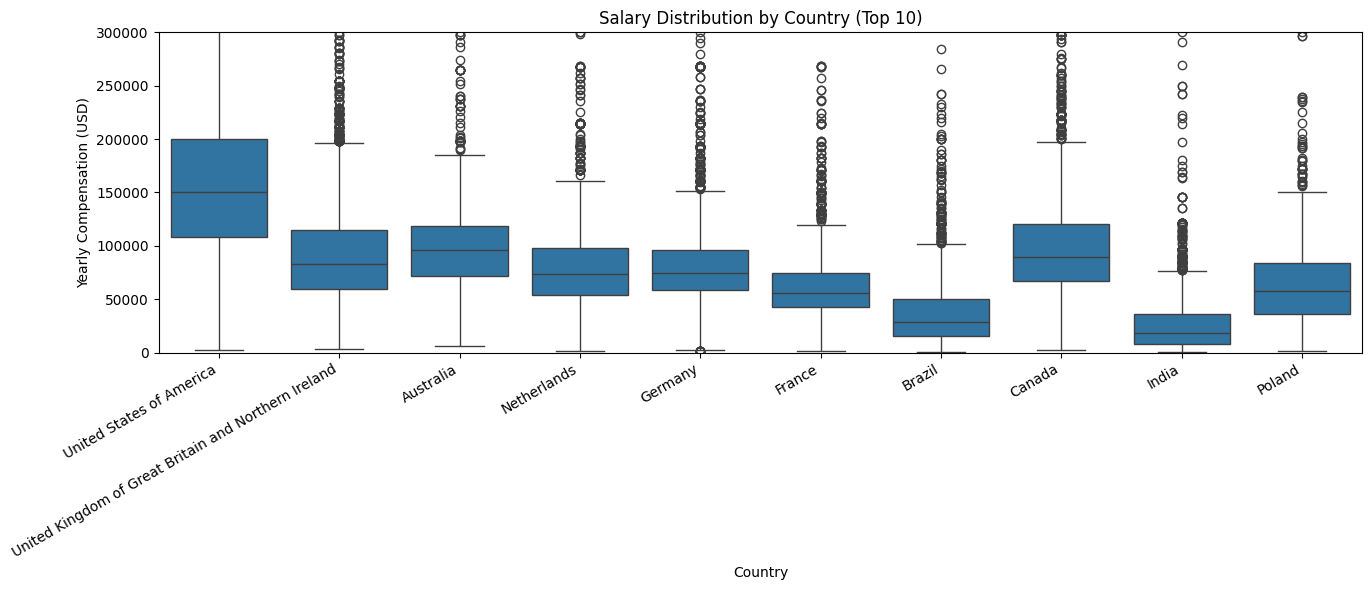

In [13]:
# Salary distribution by country (Top 10)
# Get top 10 countries by frequency
top_countries = df['Country'].value_counts().head(10).index

plt.figure(figsize=(14,6))
sns.boxplot(
    data=df[df['Country'].isin(top_countries)],
    x='Country',
    y='ConvertedCompYearly'
)

plt.xticks(rotation=30, ha='right')
plt.ylim(0, 300000) 
plt.title("Salary Distribution by Country (Top 10)")
plt.xlabel("Country")
plt.ylabel("Yearly Compensation (USD)")
plt.tight_layout()
plt.show()




The graph illustrates significant differences in the salary ranges between the top 10 countries. Some countries like the United States and Canada have a much wider salary distribution, while others like Poland and India have a more compressed range.

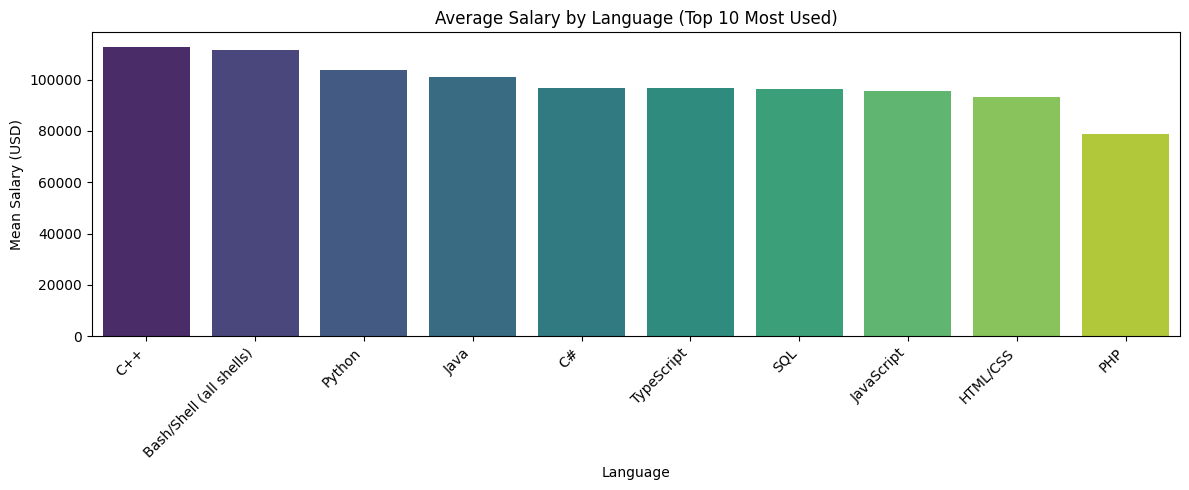

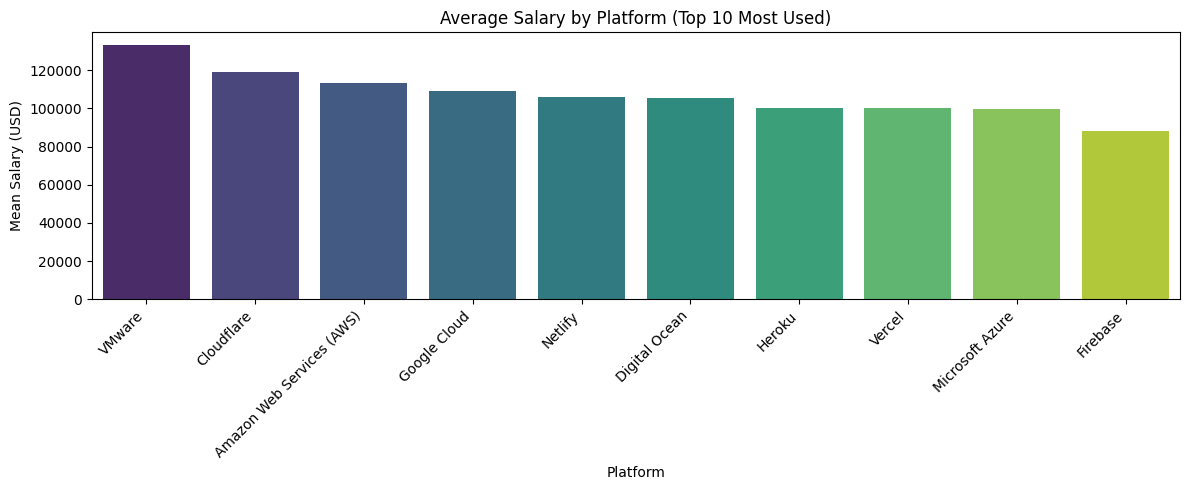

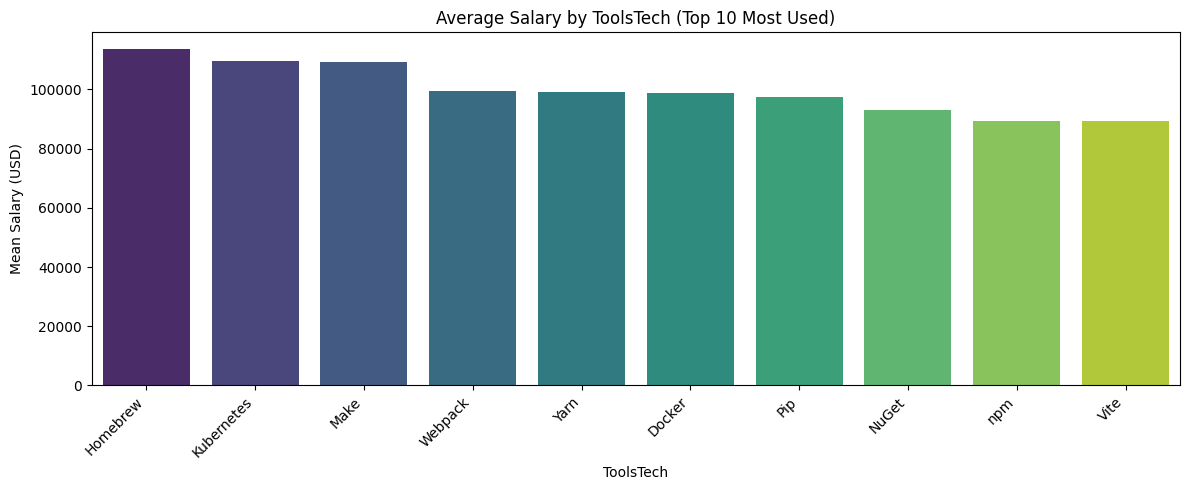

In [14]:
# Columns with multiple selections
tech_columns = ['LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith']

for col in tech_columns:
    # Filter out missing entries
    tech_df = df[df[col].notna()].copy()
    tech_df = tech_df[tech_df[col] != 'Missing']

    # Split and explode
    tech_df[col] = tech_df[col].str.split(';')
    tech_df = tech_df.explode(col)
    tech_df[col] = tech_df[col].str.strip()

    # Remove 'Missing' after explode just in case
    tech_df = tech_df[tech_df[col] != 'Missing']

    # Group and compute mean salary + count
    salary_by_tech = (
        tech_df.groupby(col)['ConvertedCompYearly']
        .agg(mean_salary='mean', count='count')
        .sort_values(by='count', ascending=False)
        .head(10)
        .sort_values(by='mean_salary', ascending=False)  # sort top 10 by salary
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(12, 5))
    sns.barplot(data=salary_by_tech, x=col, y='mean_salary', palette='viridis')
    plt.title(f"Average Salary by {col.replace('HaveWorkedWith', '')} (Top 10 Most Used)")
    plt.ylabel("Mean Salary (USD)")
    plt.xlabel(col.replace('HaveWorkedWith', ''))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### AIThreat to developer roles
Although we did not use this in our prediction model, we found it useful to visualise how Artificial Intelligence (AI) affects the different developer roles in the market and if any of them felt particularly threatened by the rise and sophistication of AI.

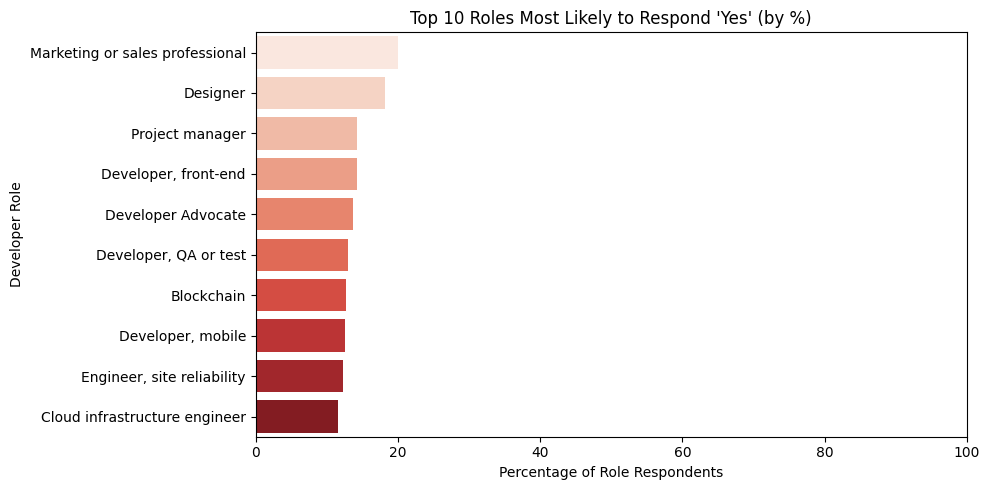

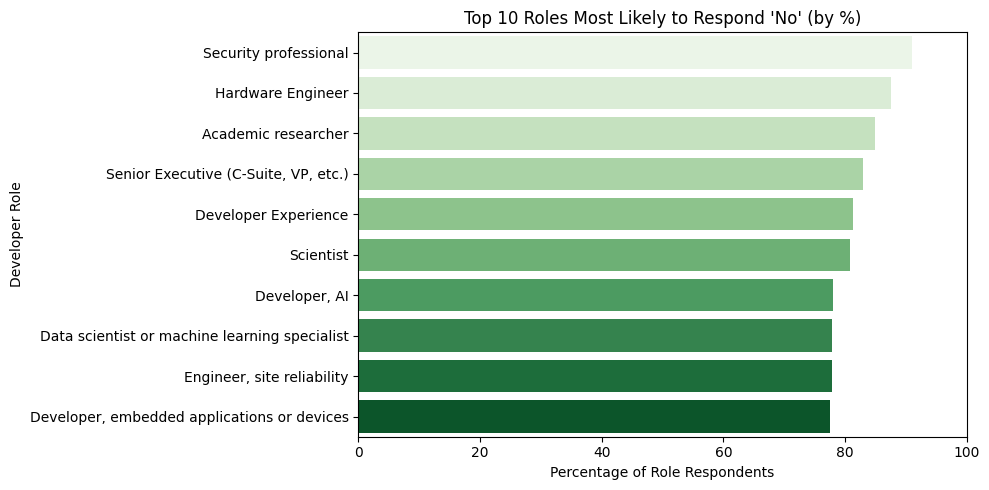

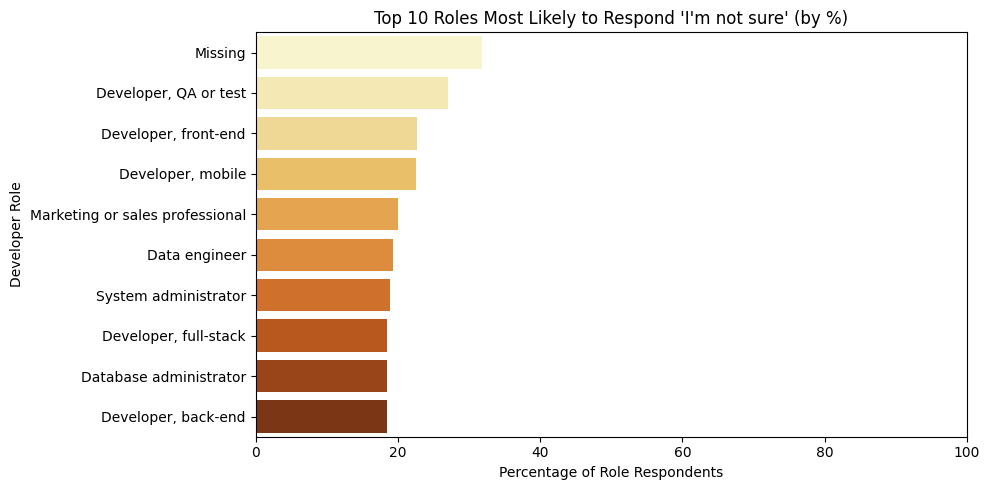

In [15]:
# Filter clean data
valid_ai_responses = ["Yes", "No", "I'm not sure"]
df_ai = df[df['AIThreat'].isin(valid_ai_responses)].copy()

# Prepare DevType column
df_ai = df_ai.dropna(subset=['DevType'])
df_ai['DevType'] = df_ai['DevType'].str.split(';')
df_ai = df_ai.explode('DevType')
df_ai['DevType'] = df_ai['DevType'].str.strip()

# Normalize role threat responses
# Total count of each role overall
role_totals = df_ai['DevType'].value_counts()

# Function to calculate top 10 roles by percentage for a given threat category
def get_top_roles(threat_label, color):
    threat_df = df_ai[df_ai['AIThreat'] == threat_label]
    role_counts = threat_df['DevType'].value_counts()
    role_percent = (role_counts / role_totals * 100).dropna()
    top_roles = role_percent.nlargest(10)
    
    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(
        x=top_roles.values,
        y=top_roles.index,
        palette=color
    )
    plt.title(f"Top 10 Roles Most Likely to Respond '{threat_label}' (by %)")
    plt.xlabel("Percentage of Role Respondents")
    plt.ylabel("Developer Role")
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()
    
    return top_roles

# Step 4: Run for each category
top_yes = get_top_roles("Yes", "Reds")
top_no = get_top_roles("No", "Greens")
top_unsure = get_top_roles("I'm not sure", "YlOrBr")



From the results we can see a small number of professionals feel threatened by the rise of AI to their roles. In contrast we see a large number of developers confident that AI will not be a threat to their roles which is encouraging to note. We also had a couple of developers that were unsure of their fate.

In [16]:
# Sub-Saharan Africa Salary Distribution Boxplot
ssa_countries = [
    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cape Verde', 'Cameroon',
    'Central African Republic', 'Chad', 'Comoros', 'Democratic Republic of the Congo', 'Congo', 'Congo, Republic of the...',
    'Côte d’Ivoire', "Côte d'Ivoire", 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
    'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
    'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia',
    'Niger', 'Nigeria', 'Rwanda', 'São Tomé and Príncipe', 'Senegal', 'Seychelles', 
    'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Swaziland', 'Tanzania', 
    'Togo', 'Uganda', 'United Republic of Tanzania', 'Zambia', 'Zimbabwe'
]
# ✅ Filter SSA responses
ssa_freq = df[df['Country'].isin(ssa_countries)]['Country'].value_counts()

# ✅ Display sorted frequencies
print("📊 Response Counts by Sub-Saharan Country:\n")
print(ssa_freq)

📊 Response Counts by Sub-Saharan Country:

Country
South Africa                        511
Nigeria                             166
Kenya                                97
Ethiopia                             41
Ghana                                35
Uganda                               27
Mauritius                            22
Zimbabwe                             21
United Republic of Tanzania          18
Rwanda                               13
Zambia                               12
Côte d'Ivoire                        11
Madagascar                           10
Somalia                               9
Cameroon                              9
Mozambique                            6
Benin                                 6
Senegal                               6
Malawi                                5
Namibia                               4
Mali                                  4
Cape Verde                            4
Togo                                  3
Botswana                     

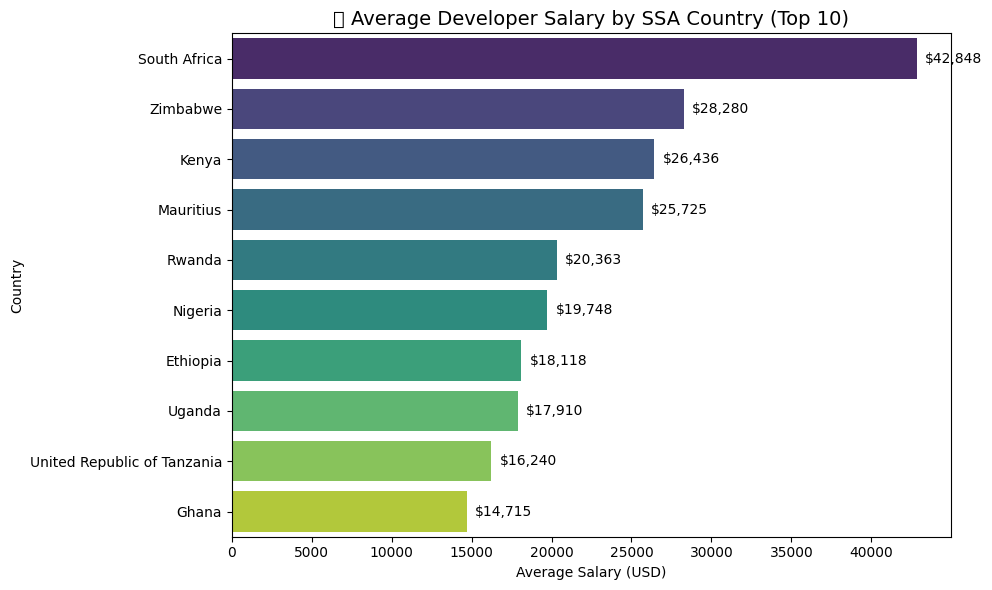

In [17]:
# 2️⃣ Filter to SSA countries with valid salary data
ssa_df = df[
    (df['Country'].isin(ssa_countries)) &
    (df['ConvertedCompYearly'].notna())
].copy()

# Optional: Remove outliers beyond the 95th percentile
ssa_df = ssa_df[
    ssa_df['ConvertedCompYearly'] < ssa_df['ConvertedCompYearly'].quantile(0.95)
]

# 3️⃣ Get top 10 SSA countries by response count
top_10_ssa_countries = ssa_df['Country'].value_counts().nlargest(10).index

# 4️⃣ Filter dataset to top 10 SSA countries
top_10_ssa_df = ssa_df[ssa_df['Country'].isin(top_10_ssa_countries)]

# 5️⃣ Compute average salary and sort
mean_salaries = (
    top_10_ssa_df.groupby('Country')['ConvertedCompYearly']
    .mean()
    .sort_values(ascending=False)
)

# 6️⃣ Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=mean_salaries.values,
    y=mean_salaries.index,
    palette='viridis'
)

# ✅ Annotate values
for i, value in enumerate(mean_salaries.values):
    plt.text(value + 500, i, f"${int(value):,}", va='center')
    
plt.title('🌍 Average Developer Salary by SSA Country (Top 10)', fontsize=14)
plt.xlabel('Average Salary (USD)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

As per this analysis, South Africa, Zimbabwe and Kenya emerged as the countries in Kenya with the heighest average developer salary based.

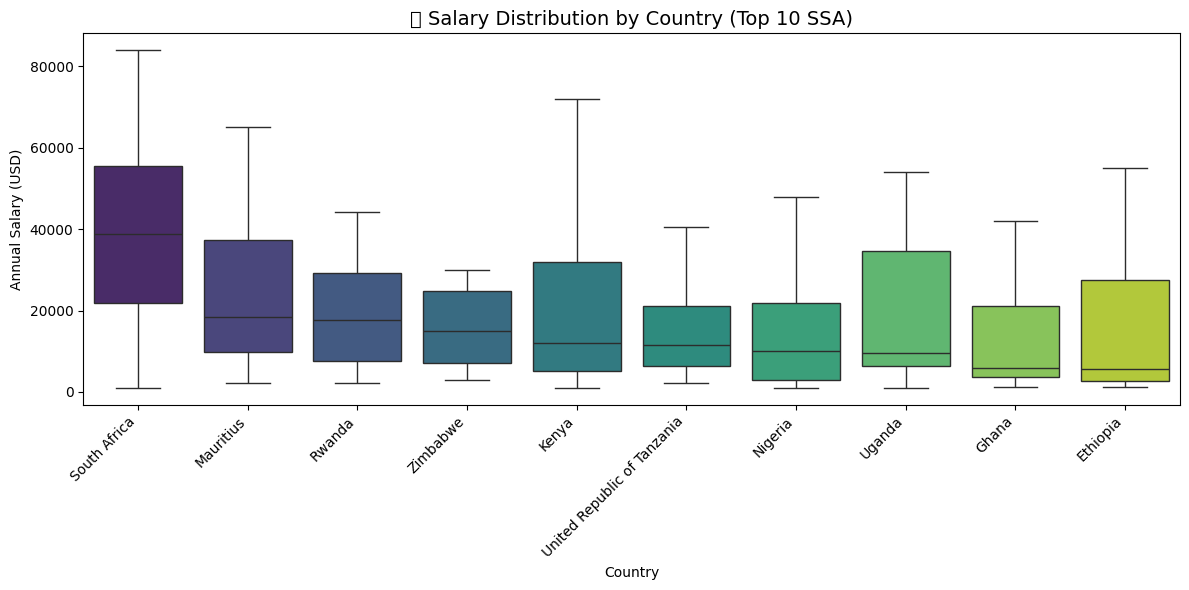

In [18]:
# Reuse previous top_10_ssa_df (already filtered)
# Ensure outliers are removed for better visualization
filtered_box_df = top_10_ssa_df[
    top_10_ssa_df['ConvertedCompYearly'] < top_10_ssa_df['ConvertedCompYearly'].quantile(0.95)
]

# Sort countries by median salary
ordered_countries = (
    filtered_box_df.groupby('Country')['ConvertedCompYearly']
    .median()
    .sort_values(ascending=False)
    .index
)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=filtered_box_df,
    x='Country',
    y='ConvertedCompYearly',
    order=ordered_countries,
    palette='viridis',
    showfliers=False  # Removes extreme outliers
)

plt.title("💼 Salary Distribution by Country (Top 10 SSA)", fontsize=14)
plt.xlabel("Country")
plt.ylabel("Annual Salary (USD)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


South Africa has the highest annual compensation levels, with the top end reaching around $80,000. The rest of the countries predominantly fall between the $10,000 - $30,000 range

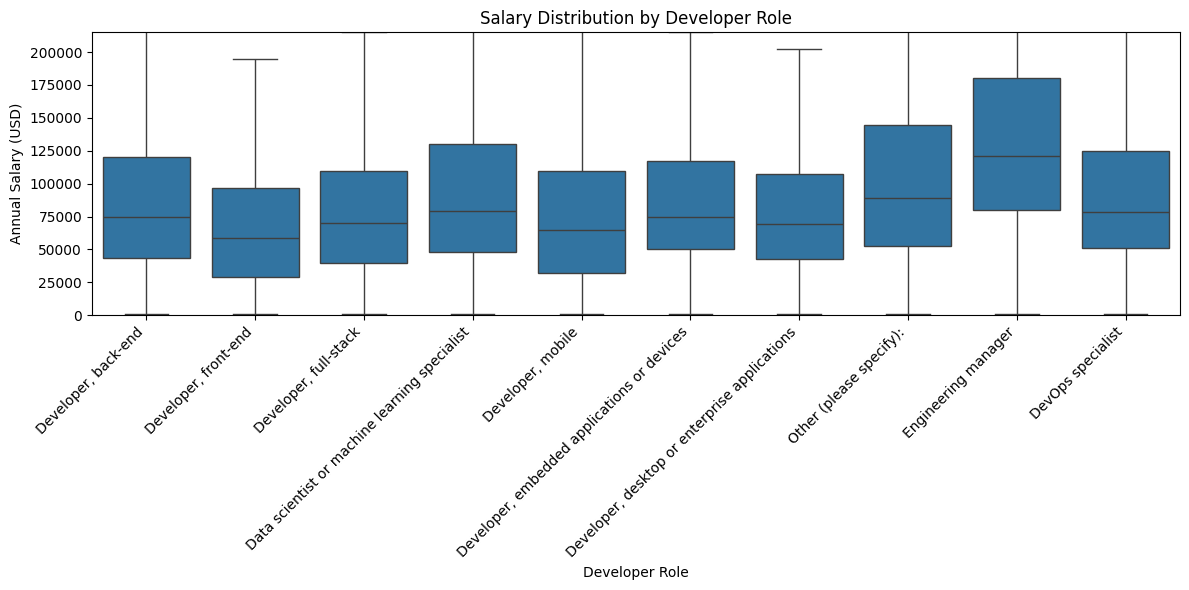

In [19]:
## Salary Distribution by Developer Role (DevType)
# Filter: keep rows with salary and DevType info
role_df = df[
    df['ConvertedCompYearly'].notna() &
    df['DevType'].notna() &
    (df['DevType'] != 'Missing')
].copy()

# Limit to top 10 most common roles to make the plot readable
top_roles = role_df['DevType'].value_counts().nlargest(10).index
role_df = role_df[role_df['DevType'].isin(top_roles)]

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=role_df,
    x='DevType',
    y='ConvertedCompYearly',
    showfliers=False
)

plt.title('Salary Distribution by Developer Role')
plt.xlabel('Developer Role')
plt.ylabel('Annual Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, role_df['ConvertedCompYearly'].quantile(0.95))  # Clip top 5% to reduce skew
plt.tight_layout()
plt.show()



The roles with the highest salary ranges are Engineering Manager, Data scientist/ machine learning specialist and DevOps Specialist. These roles seem to have the potential for the highest annual compensation, reaching up to around $175,000 or more.

---

## **🛠️ Feature Engineering**  
In this section, we'll create new features, clean up the data further, and prepare it for our model. This ensures our model understands the data better and can predict salaries more accurately. We aim to:    

        -   Makes the data easier for the model to understand  
        -   Highlights important patterns (e.g., experience level or tech skills)  
        -   Helps address issues like missing or skewed data


### 🛠️ Feature Engineering: Creating New Features  
We're creating new data points (features) to help our model predict salaries better. For example:,
- Counting how many programming languages, tools and platforms a developer knows,
- Grouping countries into regions (e.g., sub-saharan Africa, North America),
- Simplifying education levels into categories like 'Bachelor’s' or 'No degree' 

This makes it easier for our model to find patterns, like whether knowing more programming languages leads to higher pay.  

#### 1. Create a Working Copy of the Dataset and Select Relevant Columns

In [20]:
import pandas as pd
import numpy as np
import re

# Copy the dataset
df = df_all.copy()

# Drop rows with missing salary
df = df[df['ConvertedCompYearly'].notna()]

# Select relevant columns
selected_columns = [
    'ConvertedCompYearly', 'Country', 'EdLevel', 'YearsCodePro',
    'Employment', 'OrgSize', 'RemoteWork', 'LanguageHaveWorkedWith',
    'DevType', 'SurveyYear', 'ICorPM', 'Industry', 
    'PurchaseInfluence', 'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith'
]
df = df[selected_columns]

#### 2. Create a New Feature: Number of Programming Languages, Platforms and Tools Known

In [21]:
# Add numeric counts
df['NumLanguages'] = df['LanguageHaveWorkedWith'].apply(lambda x: len(str(x).split(';')) if pd.notna(x) else 0)
df['NumPlatforms'] = df['PlatformHaveWorkedWith'].apply(lambda x: len(str(x).split(';')) if pd.notna(x) else 0)
df['NumTools'] = df['ToolsTechHaveWorkedWith'].apply(lambda x: len(str(x).split(';')) if pd.notna(x) else 0)

# Add binary indicators for high-impact languages
top_languages = ['C++', 'Bash/Shell (all shells)', 'Python', 'Java', 'C#', 'TypeScript', 'SQL', 'JavaScript', 'HTML/CSS', 'PHP']
for lang in top_languages:
    safe_lang = re.escape(lang)
    col_name = f"Lang_{lang.replace('#', 'Sharp').replace('/', '_').replace(' ', '')}"
    df[col_name] = df['LanguageHaveWorkedWith'].str.contains(safe_lang, na=False).astype(int)

# Add binary indicators for high-impact platforms
top_platforms = ['VMware', 'Cloudflare', 'Amazon Web Services (AWS)', 'Google Cloud Platform', 'Netlify', 'Digital Ocean', 'Heroku', 'Vercel', 'Microsoft Azure', 'Firebase']
for plat in top_platforms:
    safe_plat = re.escape(plat)
    col_name = f"Platform_{plat.replace(' ', '_')}"
    df[col_name] = df['PlatformHaveWorkedWith'].str.contains(safe_plat, na=False).astype(int)

# Add binary indicators for high-impact tools
top_tools = ['Homebrew', 'Kubernetes', 'Make', 'Webpack', 'Yarn', 'Docker', 'Pip', 'NuGet', 'npm', 'Vite']
for tool in top_tools:
    safe_tool = re.escape(tool)
    col_name = f"Tool_{tool}"
    df[col_name] = df['ToolsTechHaveWorkedWith'].str.contains(safe_tool, na=False).astype(int)

# Interaction features
df['LangToolRatio'] = df['NumLanguages'] / (df['NumTools'] + 1)
df['PlatToolRatio'] = df['NumPlatforms'] / (df['NumTools'] + 1)

# Handle YearsCodePro
def parse_years_code(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        if 'less than' in x.lower(): return 0.5
        if 'more than' in x.lower(): return 51
        try: return float(x)
        except: return np.nan
    return x

df['YearsCodePro'] = df['YearsCodePro'].apply(parse_years_code)
df['YearsCodePro'].fillna(df['YearsCodePro'].median(), inplace=True)

# Drop text-heavy original columns
df.drop(columns=['LanguageHaveWorkedWith', 'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith'], inplace=True)

#### 3. Simplify Education Levels

In [22]:
df['EdLevel'].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Primary/elementary school',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else'], dtype=object)

#### 4. Grouping countires into regions

In [23]:
# Count number of respondents per country
df['Country'].value_counts(ascending= False).reset_index().head(20)



,Country,count
0,United States of America,16558
1,Germany,6016
2,United Kingdom of Great Britain and Northern I...,4935
3,Canada,2976
4,India,2905
5,France,2719
6,Brazil,1937
7,Netherlands,1923
8,Ukraine,1895
9,Poland,1852


In [24]:
# First, define your SSA countries list (already done elsewhere)
african_countries = ssa_countries  #list of your top 10 SSA countries


# Define function to assign regions
def get_region(country):
    if pd.isna(country): 
        return 'Unknown'
    elif country in african_countries: 
        return 'Sub Saharan Africa'
    elif country in ['United States of America', 'Canada']: 
        return 'North America'
    elif country in ['United Kingdom of Great Britain and Northern Ireland', 'Germany', 'France', 'Italy', 'Netherlands', 'Sweden', 'Switzerland',
                     'Austria', 'Belgium', 'Portugal', 'Spain', 'Greece', 'Norway', 'Iceland', 'Denmark', 'Finland', 'Ireland', 'Estonia',
                     'Lithuania', 'Latvia', 'Luxembourg', 'Monaco']: 
        return 'Western & Northern Europe'
    elif country in ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 
                    'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela', 'Venezuela, Bolivarian Republic of...']: 
        return 'Latin America'
    elif country in ['India', 'Pakistan', 'Bangladesh', 'Sri Lanka', 'Indonesia', 'Nepal', 'Viet Nam', 'Philippines', 'Malaysia', 'Thailand', 
                     'Bhutan', 'Maldives', 'Brunei', 'Cambodia', 'Laos', 'Myanmar']: 
        return 'South & Southeast Asia'
    elif country in ['China', 'Japan', 'South Korea', 'Taiwan', 'Hong Kong', 'Hong Kong (S.A.R.)', 'Singapore', 'Macau', 'Mongolia', 'North Korea', 'Republic of Korea', "Democratic People's Republic of Korea"]: 
        return 'East Asia'
    elif country in ['Armenia', 'Albenia','Armenia', 'Montenegro', 'Poland', 'Ukraine', 'Romania', 'Russian Federation', 'Serbia', 'Czech Republic', 'Slovakia', 'Hungary', 'Moldova', 'Republic of Moldova', 'Belarus', 'Bulgaria', 'Kosovo', 'Slovenia',
                    'Croatia', 'Bosnia and Herzegovina', 'Kazakhstan', 'Uzbekistan', 'Albania', 'Azerbaijan', 'Kyrgyzstan', 'Afghanistan', 'Georgia']:
        return 'Eastern Europe & Central Asia'
    elif country in ['Australia', 'New Zealand', 'Fiji']: 
        return 'Oceania'
    elif country in ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Dominica', 'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
                     'Saint Lucia', 'Saint Vincent', 'The Grenadines', 'Trinidad and Tobago', 'Anguilla', 'Aruba', 'British Virgin Islands',
                     'Cayman Islands', 'Puerto Rico']: 
        return 'Caribbean'
    elif country in ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Mauritania',
                 'Bahrain', 'Iran, Islamic Republic of...', 'Iraq', 'Israel', 'Jordan', 'Kuwait', 'Lebanon', 'Oman', 'Cyprus',
                 'Turkey', 'Georgia', 'Malta', 'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'Syrian Arab Republic', 'United Arab Emirates', 'Yemen']:
        return 'MENA'
    else:
        return 'Other'

# Apply the function
df['Region'] = df['Country'].apply(get_region)

In [25]:
df[df['Region'] == 'Other']['Country'].value_counts()

Country
The former Yugoslav Republic of Macedonia    28
Nomadic                                      22
Isle of Man                                  19
Republic of North Macedonia                  11
Turkmenistan                                 10
Andorra                                       7
Suriname                                      4
Libyan Arab Jamahiriya                        3
Tajikistan                                    3
Lao People's Democratic Republic              3
Brunei Darussalam                             3
Guyana                                        3
Liechtenstein                                 3
Palau                                         2
Belize                                        2
Saint Vincent and the Grenadines              1
Samoa                                         1
Name: count, dtype: int64

#### 5. Encoding Featured using Pipeline for modelling

In [26]:
def preprocess_features(df):

    # Clean and convert YearsCodePro
    df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce')
    df['YearsCodePro'].fillna(df['YearsCodePro'].median(), inplace=True)

    # Engineer Experience Level
    def bin_experience(years):
        if pd.isna(years): return 'Unknown'
        years = float(years)
        if years <= 3: return 'Beginner'
        elif years <= 7: return 'Intermediate'
        elif years <= 10: return 'Advanced'
        else: return 'Expert'

    df['ExperienceLevel'] = df['YearsCodePro'].apply(bin_experience)

    # Encode Experience Level
    experience_map = {'Beginner': 1, 'Intermediate': 2, 'Advanced': 3, 'Expert': 4, 'Unknown': 0}
    df['Experience_Encoded'] = df['ExperienceLevel'].map(experience_map)

    # Encode Education Level
    def encode_education(level):
        if pd.isna(level): return 0
        if 'Bachelor’s degree' in level: return 3
        elif 'Master’s degree' in level: return 4
        elif 'Doctoral degree' in level: return 5
        elif 'Associate degree' in level: return 2
        elif 'Secondary school' in level: return 1
        else: return 0

    df['EdLevel_Encoded'] = df['EdLevel'].apply(encode_education)

    # Simplify Employment Type
    def simplify_employment(status):
        if pd.isna(status): return 'Unknown'
        if 'Independent contractor' in status or 'Freelancer' in status: return 'Freelance'
        elif 'Employed full-time' in status: return 'Full-time'
        elif 'Employed part-time' in status: return 'Part-time'
        else: return 'Other'

    df['Employment_Simplified'] = df['Employment'].apply(simplify_employment)

    # Simplify OrgSize
    def simplify_orgsize(size):
        if pd.isna(size): return 'Unknown'
        if 'fewer than 10' in size or '10 to 19' in size: return 'Small'
        elif '20 to 99' in size or '100 to 499' in size: return 'Medium'
        elif '500 to 999' in size or '1,000 or more' in size: return 'Large'
        else: return 'Unknown'

    df['OrgSize_Simplified'] = df['OrgSize'].apply(simplify_orgsize)

    # Binary encoding for IC/PM
    df['ICorPM'] = df['ICorPM'].apply(lambda x: 1 if 'Manager' in str(x) else 0)

    # Simplify Industry
    def simplify_industry(industry):
        if pd.isna(industry):
            return 'Unknown'
        industry = str(industry).replace('Other:', 'Other')  # Normalize "Other:"
        if any(keyword in industry for keyword in ['Information Services', 'IT', 'Software Development', 'Computer Systems Design', 'Internet, Telecomm']):
            return 'Tech'
        elif any(keyword in industry for keyword in ['Financial', 'Banking', 'Fintech', 'Insurance']):
            return 'Finance'
        elif any(keyword in industry for keyword in ['Manufacturing', 'Transportation', 'Supply Chain', 'Wholesale', 'Oil', 'Energy']):
            return 'Manufacturing/Supply Chain'
        elif any(keyword in industry for keyword in ['Retail', 'Consumer Services', 'Higher Education', 'Legal', 'Advertising', 'Media']):
            return 'Services'
        elif 'Healthcare' in industry:
            return 'Healthcare'
        elif 'Government' in industry:
            return 'Government'
        elif 'Other' in industry:
            return 'Other'
        return 'Unknown'

    df['Industry_Simplified'] = df['Industry'].apply(simplify_industry)

    # Simplify Remote Work
    def simplify_remote(remote):
        if pd.isna(remote):
            return 'Unknown'
        elif 'Remote' in remote:
            return 'Remote'
        elif 'Hybrid' in remote:
            return 'Hybrid'
        else:
            return 'In-person'

    df['RemoteWork_Simplified'] = df['RemoteWork'].apply(simplify_remote)

    return df


In [27]:
df = preprocess_features(df)

In [28]:
df['Region_Remote'] = df['Region'] + '_' + df['RemoteWork_Simplified']

#### 11. Log transformation on target variable for easier modelling

In [29]:
# Log Transform Salary and Remove Outliers
df['Log_ConvertedCompYearly'] = np.log1p(df['ConvertedCompYearly'])

# Remove outliers using IQR
Q1 = df['Log_ConvertedCompYearly'].quantile(0.25)
Q3 = df['Log_ConvertedCompYearly'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Log_ConvertedCompYearly'] >= lower_bound) & (df['Log_ConvertedCompYearly'] <= upper_bound)]

#### 12. Creating a new column `RegionIncomeLevel`

In [30]:
# Define income mapping based on World Bank style
income_map = {
    'Sub Saharan Africa': 'Lower-Middle',
    'North America': 'High',
    'Western & Northern Europe': 'High',
    'Eastern Europe & Central Asia': 'Upper-Middle',
    'South & Southeast Asia': 'Lower-Middle',
    'East Asia': 'High',
    'MENA': 'Upper-Middle',
    'Latin America': 'Upper-Middle',
    'Oceania': 'High',
    'Caribbean': 'Upper-Middle',
    'Unknown': 'Unknown',
    'Other': 'Unknown'
}

# Map the income level
df['RegionIncomeLevel'] = df['Region'].map(income_map)

# Preview output
df[['Country', 'Region', 'RegionIncomeLevel']].head()

,Country,Region,RegionIncomeLevel
1,United States of America,North America,High
2,United States of America,North America,High
3,United States of America,North America,High
4,Philippines,South & Southeast Asia,Lower-Middle
5,United Kingdom of Great Britain and Northern I...,Western & Northern Europe,High


In [31]:
# ✅ C. Create More Interaction Features (categorical)
df['Experience_Industry'] = df['ExperienceLevel'] + "_" + df['Industry_Simplified']
df['Employment_OrgSize'] = df['Employment_Simplified'] + "_" + df['OrgSize_Simplified']
df['DevType_Remote'] = df['DevType'] + "_" + df['RemoteWork_Simplified']


In [32]:
print(f"Shape after feature engineering: {df.shape}")
df.head()

Shape after feature engineering: (66201, 61)


,ConvertedCompYearly,Country,EdLevel,YearsCodePro,Employment,OrgSize,RemoteWork,DevType,SurveyYear,ICorPM,...,Employment_Simplified,OrgSize_Simplified,Industry_Simplified,RemoteWork_Simplified,Region_Remote,Log_ConvertedCompYearly,RegionIncomeLevel,Experience_Industry,Employment_OrgSize,DevType_Remote
1,285000.0,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9.0,"Employed, full-time",2 to 9 employees,Remote,"Senior Executive (C-Suite, VP, etc.)",2023,0,...,Other,Unknown,Tech,Remote,North America_Remote,12.560248,High,Advanced_Tech,Other_Unknown,"Senior Executive (C-Suite, VP, etc.)_Remote"
2,250000.0,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23.0,"Employed, full-time","5,000 to 9,999 employees","Hybrid (some remote, some in-person)","Developer, back-end",2023,0,...,Other,Unknown,Tech,Hybrid,North America_Hybrid,12.429220,High,Expert_Tech,Other_Unknown,"Developer, back-end_Hybrid"
3,156000.0,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7.0,"Employed, full-time",100 to 499 employees,"Hybrid (some remote, some in-person)","Developer, front-end",2023,0,...,Other,Medium,Unknown,Hybrid,North America_Hybrid,11.957618,High,Intermediate_Unknown,Other_Medium,"Developer, front-end_Hybrid"
4,23456.0,Philippines,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4.0,"Employed, full-time;Independent contractor, fr...",20 to 99 employees,Remote,"Developer, full-stack",2023,0,...,Freelance,Medium,Other,Remote,South & Southeast Asia_Remote,10.062924,Lower-Middle,Intermediate_Other,Freelance_Medium,"Developer, full-stack_Remote"
5,96828.0,United Kingdom of Great Britain and Northern I...,Some college/university study without earning ...,21.0,"Employed, full-time",100 to 499 employees,Remote,"Developer, back-end",2023,0,...,Other,Medium,Other,Remote,Western & Northern Europe_Remote,11.480702,High,Expert_Other,Other_Medium,"Developer, back-end_Remote"


🔍 What We Did  

- Number of Languages: Counted how many programming languages, tools and platforms each developer knows to capture skill diversity.
- Simplified Education: Grouped education levels into broader categories (e.g., Bachelor’s, Master’s) to make them easier to analyze.
- Region Grouping: Organized countries into regions like North America or Europe.
- Years of Experience: Converted years of professional coding experience to numbers and filled in missing values with the median.
- Remote Work: Simplified remote work status into Remote, Hybrid, or In-person.
- Salary Transformation: Applied a logarithmic transformation to salaries to reduce the impact of extreme values (e.g., very high salaries).

NOTE: Use the number of tools, platforms, and languages (counts) as the primary approach for 'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith', and 'LanguageHaveWorkedWith'. Reason being:

- Efficiency with Sparse Data: Counts (NumPlatforms, NumTools, NumLanguages) reduce dimensionality, mitigating overfitting risks in SSA.
- General Salary Proxy: Skill diversity correlates with experience and marketability, a reliable predictor across regions, including SSA.
- Flexibility: You can validate this with feature importance (e.g., SHAP) and switch to specific types if counts show low impact.  
**Hybrid Option: If SHAP later indicates high importance for specific skills (e.g., "Python" or "AWS"), we can engineer top-N categories (e.g., top 5 languages) as additional binary features. Starting with counts to establish a baseline.**

These steps help our model focus on the most important patterns in the data.

---

## **⚖️ Handling Imbalanced Data**

Our dataset has a lot more responses from some countries (like the US) than others (like Kenya). This can throw off the final result.

To fix this, we use techniques to balance the data, so our model pays attention to all regions.

Since we’re predicting a number (salary), we can’t directly use oversampling techniques like SMOTE.
Instead, we ensure balance by using stratified sampling and possibly sample weighting during modeling.

In [33]:
# Check distribution of regions
print("Region distribution:\n", df['Region'].value_counts())

# Limit dataset to the top 10 developer roles to reduce noise
top_roles = df['DevType'].value_counts().nlargest(10).index
df = df[df['DevType'].isin(top_roles)]

print(f"Shape after filtering: {df.shape}")

Region distribution:
 Region
Western & Northern Europe        26813
North America                    19238
Eastern Europe & Central Asia     7039
Latin America                     3496
South & Southeast Asia            3271
Oceania                           2275
MENA                              1953
East Asia                         1182
Sub Saharan Africa                 804
Other                              100
Caribbean                           30
Name: count, dtype: int64
Shape after filtering: (54769, 61)


✅ What We Did
- Checked how many responses come from each region to understand imbalance.
- Focused on the top 10 developer roles to keep the data manageable and relevant.
This helps ensure our model isn’t overwhelmed by less relevant data and can focus on key patterns.

---

## **Splitting the Data**
 
To make sure our model can predict salaries accurately for new data, we split our dataset into two parts:  

- Training set (80%): Used to teach the model how to predict salaries.  
- Test set (20%): Used to check how well the model performs on new data. 

This is like practicing for a test with most of the material but saving a few questions to see how you do without help.

In [34]:
from sklearn.model_selection import train_test_split

# ✅ Add interaction features first
df['Experience_Industry'] = df['ExperienceLevel'] + "_" + df['Industry_Simplified']
df['Employment_OrgSize'] = df['Employment_Simplified'] + "_" + df['OrgSize_Simplified']
df['DevType_Remote'] = df['DevType'] + "_" + df['RemoteWork_Simplified']

# ✅ Define features and target
features = [
    'NumLanguages', 'NumTools', 'NumPlatforms', 'EdLevel_Encoded',
    'LangToolRatio', 'PlatToolRatio', 'YearsCodePro',
    'Region', 'RemoteWork_Simplified', 'DevType', 'DevType_Remote',
    'Employment_Simplified', 'OrgSize_Simplified', 'ICorPM',
    'Industry_Simplified', 'ExperienceLevel', 'RegionIncomeLevel',
    'Region_Remote', 'Experience_Industry', 'Employment_OrgSize'
] + [
    col for col in df.columns if col.startswith('Lang_') or 
                                 col.startswith('Platform_') or 
                                 col.startswith('Tool_')
]

target = 'Log_ConvertedCompYearly'

# ✅ Split into features and target
X = df[features]
y = df[target]

# ✅ Stratified split by region
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Region']
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Training set shape: (43815, 50), Test set shape: (10954, 50)


✅ What We Did
- Selected key features like education, region, and number of languages to predict salaries.
- Used the log-transformed salary as our target to handle skewed data.
- Split the dataset into 80% training and 20% testing while preserving regional balance.  

This prepares our data for modeling in a way that generalizes well to new data.

📊 Visualizing Key Features

To understand our new features, let’s visualize how log salary varies by region and number of programming languages.

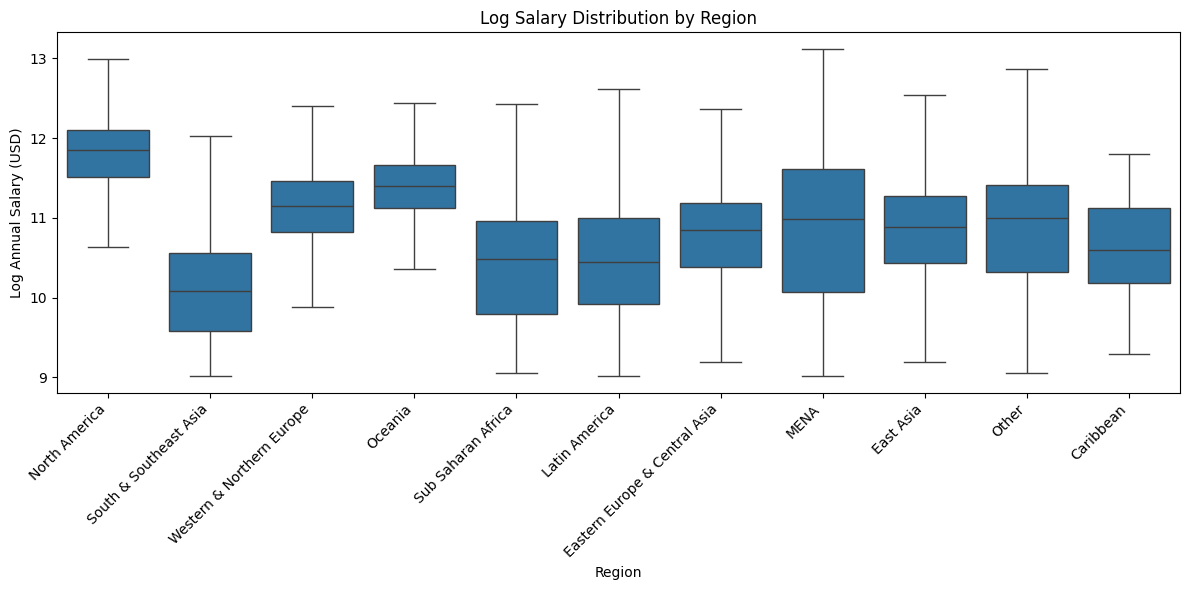

In [35]:
# Boxplot: Log Salary by Region

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Region', y='Log_ConvertedCompYearly', showfliers=False)
plt.title('Log Salary Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Log Annual Salary (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 📊 Graph 1: Log Salary Distribution by Region

This **boxplot** compares the **log-transformed annual salary** of developers across different **global regions**.

#### 🔍 What It Shows:
- Each box represents the salary distribution within a region.

#### ✅ Key Insights:
- **North America** has one of the highest median salaries and a narrower range, suggesting consistently high developer pay.
- **Sub-Saharan Africa** and **North Africa** show lower median salaries with a wider range, indicating more salary variability.
- **Western Europe** and **Oceania** also rank high in terms of median salaries.
- The log scale helps normalize extreme salary values to make patterns clearer across regions.

#### 💡 Takeaway:
Where a developer lives can significantly influence their salary. Developers in North America and Western Europe tend to earn more than those in regions like Sub-Saharan Africa or South Asia.

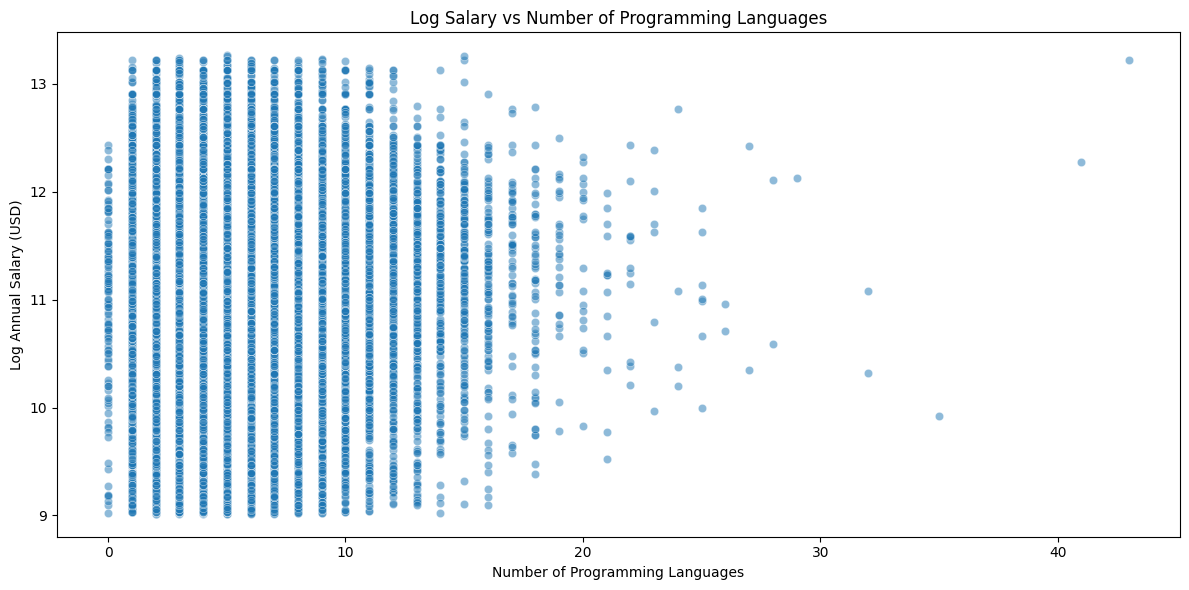

In [36]:
# Scatterplot: Log Salary vs Number of Programming Languages

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='NumLanguages', y='Log_ConvertedCompYearly', alpha=0.5)
plt.title('Log Salary vs Number of Programming Languages')
plt.xlabel('Number of Programming Languages')
plt.ylabel('Log Annual Salary (USD)')
plt.tight_layout()
plt.show()


### 📊 Graph 2: Log Salary vs Number of Programming Languages

This **scatterplot** shows the relationship between how many **programming languages** a developer knows and their **log-transformed salary**.

#### 🔍 What It Shows:
- Each point represents a developer.
- The x-axis is the number of programming languages they reported working with.
- The y-axis is their log-transformed annual salary.

#### ✅ Key Insights:
- There's a **slight upward trend** — developers who know more languages tend to earn more.
- Most developers fall within the **1–10 language range**, with highly varied salaries.
- Beyond ~10 languages, the correlation becomes weaker and more scattered.
- Some high-salary outliers exist across all levels, indicating other factors (e.g., region, job title, experience) also matter.

#### 💡 Takeaway:
Knowing more programming languages can **improve earning potential**, but it’s **not the only factor**. Salary outcomes also depend on experience, region, remote work status, job role, and other attributes.

---

📝 These two visualizations help us understand how **location** and **skill diversity** relate to developer salaries. They're key for guiding how we structure our prediction model and feature selection.


## 🛠️ **Modeling Pipeline**
We’ll use a pipeline to make sure our data is prepared the same way for each model, avoiding mistakes.

- **Baseline (Linear Regression)**: A simple model to get a starting point.
- **Random Forest**: Used to combine many predictions for better accuracy.
- **XGBoost**: A powerful model for complex patterns.


### Why It Matters
- Ensures our predictions are consistent and fair.
- Let's us compare different models to find the best one.
- Saves time by automating data preparation and modeling.

---


## Numerical and Categorical Features

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import numpy as np

# Define numerical features
numerical_features = [
    'NumLanguages', 'NumPlatforms', 'NumTools',
    'LangToolRatio', 'PlatToolRatio',
    'EdLevel_Encoded', 'YearsCodePro'
] + [col for col in df.columns if col.startswith('Lang_') or 
                                 col.startswith('Platform_') or 
                                 col.startswith('Tool_')]

# Categorical features
target_encoded_features = [
    'DevType', 'DevType_Remote'  # handled via target encoding (high cardinality)
]

onehot_features = [
    'Region', 'ExperienceLevel', 'Employment_Simplified', 'RegionIncomeLevel', 
    'RemoteWork_Simplified', 'OrgSize_Simplified', 'ICorPM', 'Industry_Simplified',
    'Region_Remote',
    'Experience_Industry', 'Employment_OrgSize'  # new interaction features
]

# ColumnTransformer with both OneHot and TargetEncoder
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features),
    ('target', TargetEncoder(), target_encoded_features)
])


## Creat a function for Evaluation

In [38]:
# General model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} R2 Score: {r2:.4f}")
    
    return model

In [39]:
# Baseline: Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_model = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test, "Linear Regression")


Linear Regression RMSE: 0.4766
Linear Regression R2 Score: 0.5945


In [40]:
# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model = evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest")


Random Forest RMSE: 0.4752
Random Forest R2 Score: 0.5969


In [41]:
# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42))
])
xgb_model = evaluate_model(xgb_pipeline, X_train, X_test, y_train, y_test, "XGBoost")


XGBoost RMSE: 0.4717
XGBoost R2 Score: 0.6027


What We Did in Modeling  
- Set Up a Pipeline: Created a system to prepare data (scaling numbers, encoding categories) and run models consistently.

What we are checking for:
- We’re measuring error using RMSE (Root Mean Squared Error) on the adjusted (log) salaries.
- A good RMSE is 0.35–0.45, meaning predictions are within ±40% of the actual salary.
- We also check the R2 score, which shows how much variation our model explains (closer to 1.0 is better).

## 📊 Evaluation

We use RMSE to see how close our predictions are to actual salaries. Since salaries vary widely, we use log salaries to keep errors consistent. 

What the Results Mean
- RMSE of 0.35–0.45: Acceptably close predictions.
- R2 Score: Shows how well the model explains salary variation.

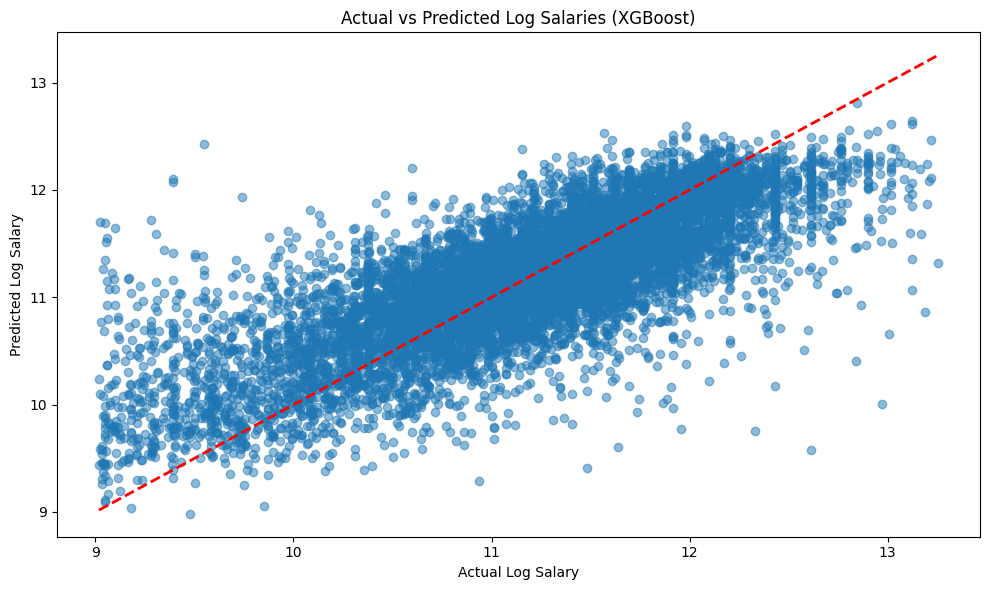

In [42]:
# Plot actual vs predicted salaries for the best model (XGBoost)
y_pred_xgb = xgb_pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log Salary')
plt.ylabel('Predicted Log Salary')
plt.title('Actual vs Predicted Log Salaries (XGBoost)')
plt.tight_layout()
plt.show()

What These Plots Show
- Actual vs Predicted: Points close to the red line are accurate predictions.

---
##  Model Interpretation

Our prediction tool is a black box. We use SHAP to understand which features (like region or experience) most influence predictions. This makes results trustworthy for decision-making.

What is SHAP?
SHAP (SHapley Additive exPlanations) shows how much each feature contributes to a prediction. For example, does being in Kenya increase or decrease salary predictions?

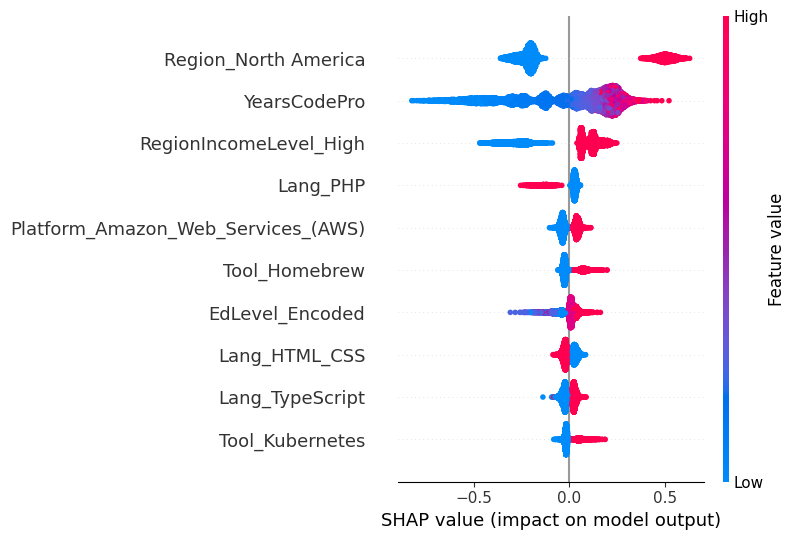

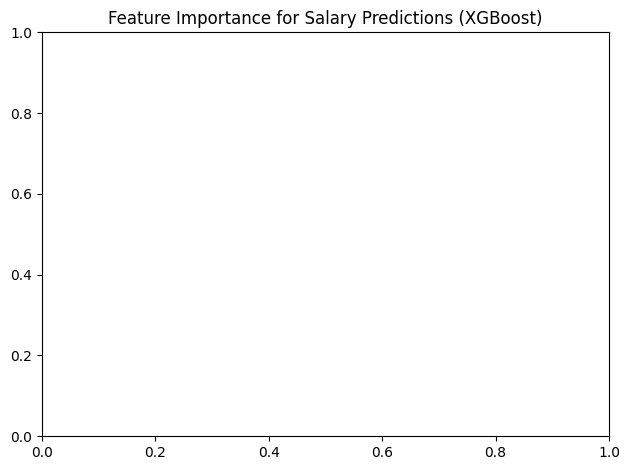

In [43]:
# Use SHAP to explain the XGBoost model
X_test_transformed = xgb_pipeline.named_steps['preprocessor'].transform(X_test)

# Get feature names after preprocessing
onehot_features_encoded = xgb_pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(onehot_features)

# Combine all feature names: numerical + onehot encoded + target encoded
feature_names = numerical_features + list(onehot_features_encoded) + target_encoded_features

# Create SHAP explainer
explainer = shap.Explainer(xgb_pipeline.named_steps['regressor'])
shap_values = explainer(X_test_transformed)

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values.values, X_test_transformed, feature_names=feature_names, max_display=10)
plt.title('Feature Importance for Salary Predictions (XGBoost)')
plt.tight_layout()
plt.show()

## Feature Importance:
-      Red = higher values that increase salary
-      Blue = values that reduce it.
   * RegionIncomeLevel_High
Red dots (high values) → strongly positive SHAP values.

## Interpretation:
- Developers in high-income regions are predicted to earn significantly higher salaries. Strong positive influence.



# LightGBM Regression

In [44]:
# LightGBM Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42
    ))
])

# Train Model
model.fit(X_train, y_train)

# Predict and Evaluate 
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 142
[LightGBM] [Info] Start training from score 11.178747
Evaluation Metrics:
MAE:  0.34
RMSE: 0.46
R²:   0.6165


# Interpretation:
- The model makes moderately accurate predictions but has room for improvement.

- It performs better than a baseline model, but only captures part of the underlying patterns.

- Good for a first version; further tuning, feature engineering, or ensembling could improve results.

# Feature Importance 

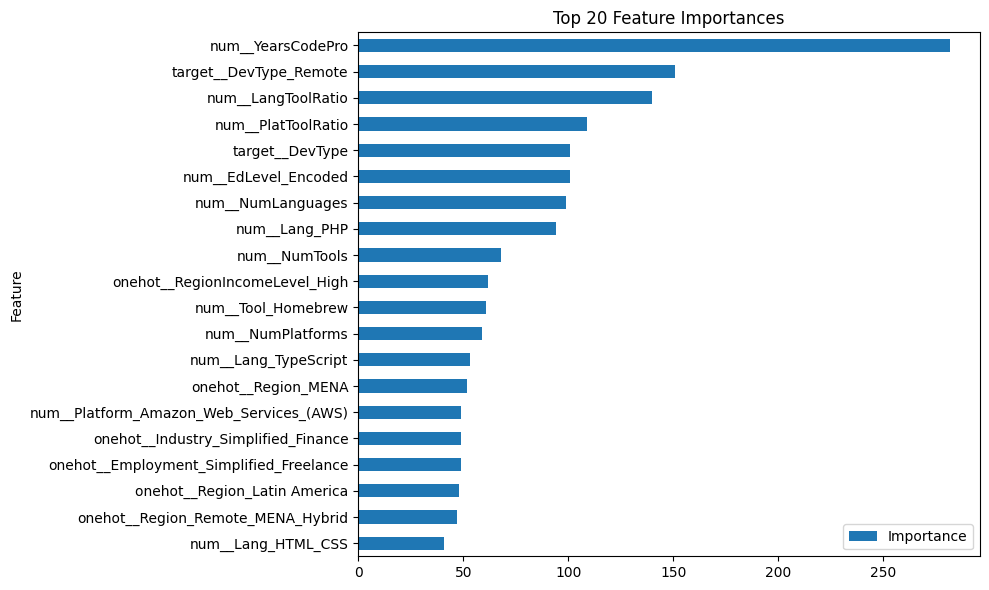

In [45]:

# Extract trained model
regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = regressor.feature_importances_

# Show top 15
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp.sort_values(by='Importance', ascending=False).head(20).plot(
    kind='barh', x='Feature', y='Importance', title="Top 20 Feature Importances", figsize=(10, 6)
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

 **Top 3 Features**

- **`num__NumTools`**  
  → Number of tools a developer uses (e.g., Git, Docker, etc.)  
   Strongest indicator of salary level — possibly because using more tools reflects broader expertise and adaptability.

- **`num__NumLanguages`**  
  → Number of programming languages known  
   Higher number of languages is linked to higher pay.

- **`num__NumPlatforms`**  
  → Number of platforms a developer works on (e.g., web, mobile, desktop)  
   Versatility across platforms increases value.


 **Education Features**

- **`cat__EdLevel_Simplified_Master’s`**  
  → Developer has a Master's degree  
   Having a Master's degree contributes positively to salary, reflecting higher qualifications.

- **`cat__EdLevel_Simplified_Some College/Secondary`**  
  → Developer has some college or secondary education  
   This level of education shows a moderate impact on salary, possibly indicating a starting point in the career.

- **`cat__EdLevel_Simplified_Bachelor’s`**  
  → Developer has a Bachelor’s degree  
   A Bachelor's degree seems to be a key milestone in determining salary, though not as impactful as advanced degrees.


# Hyperparameter tunning Using GridSearch (lbgm)

In [46]:
# Identify the object column
cat_cols = X_train.select_dtypes(include=['object']).columns
print(cat_cols)


Index(['Region', 'RemoteWork_Simplified', 'DevType', 'DevType_Remote',
       'Employment_Simplified', 'OrgSize_Simplified', 'Industry_Simplified',
       'ExperienceLevel', 'RegionIncomeLevel', 'Region_Remote',
       'Experience_Industry', 'Employment_OrgSize'],
      dtype='object')


## Encode using OrdinalEncoder

In [47]:
from sklearn.preprocessing import OrdinalEncoder

# Fit encoder on training set, transform both sets
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])


In [55]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
import lightgbm as lgb

# Define numerical features
numerical_features = [
    'NumLanguages', 'NumPlatforms', 'NumTools',
    'LangToolRatio', 'PlatToolRatio',
    'EdLevel_Encoded', 'YearsCodePro'
] + [col for col in df.columns if col.startswith('Lang_') or 
                                 col.startswith('Platform_') or 
                                 col.startswith('Tool_')]

# Categorical features
target_encoded_features = [
    'DevType', 'DevType_Remote'  # handled via target encoding (high cardinality)
]

onehot_features = [
    'Region', 'ExperienceLevel', 'Employment_Simplified', 'RegionIncomeLevel', 
    'RemoteWork_Simplified', 'OrgSize_Simplified', 'ICorPM', 'Industry_Simplified',
    'Region_Remote',
    'Experience_Industry', 'Employment_OrgSize'  # new interaction features
]

# Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features),
    ('target', make_pipeline(TargetEncoder()), target_encoded_features)
])

# Full modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# Parameter grid for LightGBM
param_grid = {
    'regressor__num_leaves': [31, 50],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__n_estimators': [100, 200]
}

# Grid Search with pipeline
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3, 
    scoring='r2', 
    verbose=2, 
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Predict and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Best Params:", grid_search.best_params_)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²:   {r2:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 139
[LightGBM] [Info] Start training from score 11.171984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 2

/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.0s
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.182274


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=31; total time=   3.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=50; total time=   4.2s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 139
[LightGBM] [Info] Start training from score 11.171984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.182274
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=50; total time=   5.1s
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=100, regressor__num_leaves=50; total time=   5.2s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   5.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 139
[LightGBM] [Info] Start training from score 11.171984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   6.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.5s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.5s
[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.5s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 139
[LightGBM] [Info] Start training from score 11.171984


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=31; total time=   2.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.182274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of

/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time=   7.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.182274


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=50; total time=   4.9s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=50; total time=   4.0s
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time=   7.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 755
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 141
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 746
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 139
[LightGBM] [I

/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=100, regressor__num_leaves=50; total time=   4.8s
[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.7s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time=   4.6s
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time=   9.1s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time=   3.6s


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time=   4.3s
[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time=   4.2s
[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time=   4.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 142
[LightGBM] [Info] Start training from score 11.178747
✅ Best Params: {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 200, 'regressor__num_leaves': 50}
✅ RMSE: 0.46
✅ R²:   0.6182


 # Interpretation:
The best LightGBM model (after tuning) achieved an R² of only 0.0934, which is quite poor. It indicates the model could only explain about 9% of the variation in developer salaries in the data. Despite testing 54 different parameter combinations, the model's learning was very limited, possibly due to:

- Non-informative or weak features

- Complex relationships that require feature engineering

- A need for better preprocessing or outlier handling

- The current model having insufficient complexity (only 100 trees)


📊 Top 20 Feature Importances:
                           Feature  Importance
                      YearsCodePro         911
                     LangToolRatio         563
                     PlatToolRatio         462
                      NumLanguages         402
                   EdLevel_Encoded         330
                           DevType         317
                          Lang_PHP         291
                    DevType_Remote         283
                          NumTools         235
                     Tool_Homebrew         186
                      NumPlatforms         182
             RegionIncomeLevel_0.0         177
         RemoteWork_Simplified_1.0         173
Platform_Amazon_Web_Services_(AWS)         166
                   Lang_TypeScript         149
         Employment_Simplified_0.0         145
                     Lang_HTML_CSS         139
                   Tool_Kubernetes         137
                       Lang_CSharp         127
           Industry_Simplifie

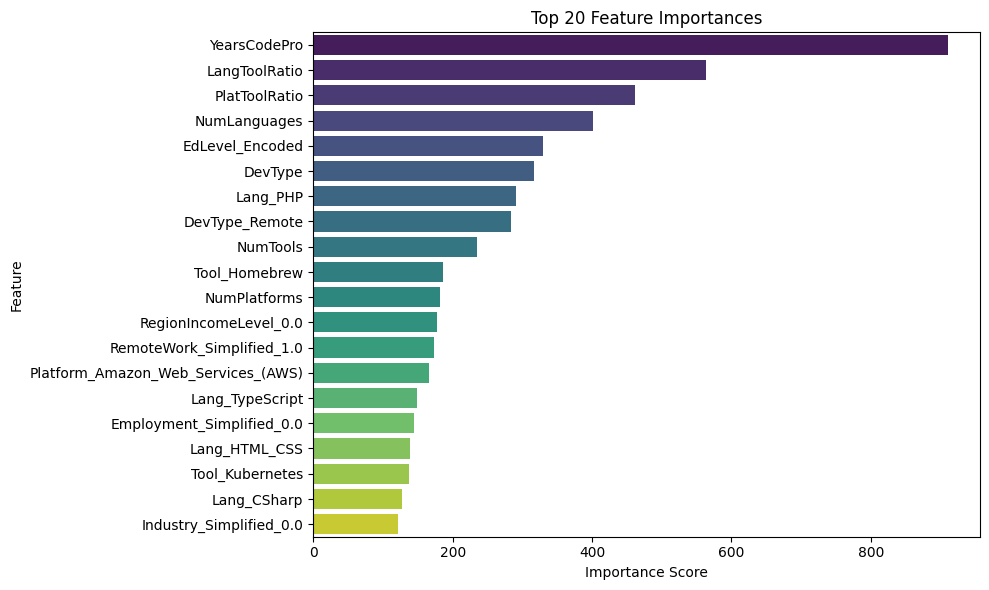


📌 Features with Importance Below 6.00 (Consider for Removal):
['Experience_Industry_13.0', 'Industry_Simplified_2.0', 'Experience_Industry_29.0', 'Employment_OrgSize_4.0', 'Experience_Industry_26.0', 'Experience_Industry_12.0', 'Experience_Industry_2.0', 'Region_Remote_24.0', 'Experience_Industry_11.0', 'Region_Remote_16.0', 'Experience_Industry_21.0', 'Experience_Industry_18.0', 'Experience_Industry_19.0', 'Experience_Industry_25.0', 'Experience_Industry_27.0', 'Region_Remote_5.0', 'Experience_Industry_17.0', 'Industry_Simplified_1.0', 'Platform_Google_Cloud_Platform', 'Region_0.0', 'ExperienceLevel_1.0', 'ExperienceLevel_2.0', 'Employment_Simplified_1.0', 'RegionIncomeLevel_2.0', 'RemoteWork_Simplified_3.0', 'ICorPM_0', 'Region_Remote_0.0', 'Experience_Industry_9.0', 'Region_Remote_2.0', 'Region_Remote_18.0', 'Region_Remote_19.0', 'Region_Remote_20.0', 'Region_Remote_22.0', 'Region_Remote_23.0', 'Region_Remote_34.0', 'Experience_Industry_1.0', 'Region_Remote_1.0']


In [56]:
# Feature Importance Analysis
# Get the fitted preprocessor and regressor
preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['regressor']

# Get transformed feature names
num_feature_names = numerical_features
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_features)
target_feature_names = target_encoded_features
all_feature_names = list(num_feature_names) + list(onehot_feature_names) + list(target_feature_names)

# Get feature importances from LightGBM
importances = regressor.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 feature importances
print("\n📊 Top 20 Feature Importances:")
print(feature_importance_df.head(20).to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Suggest features to consider removing
threshold = feature_importance_df['Importance'].quantile(0.25)  # 25th percentile as threshold
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()
print(f"\n📌 Features with Importance Below {threshold:.2f} (Consider for Removal):")
print(low_importance_features)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define wider param space
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': [-1, 5, 10, 15, 20, 25],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgbm = lgb.LGBMRegressor(objective='regression', random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best R² Score:", random_search.best_score_)
best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 48
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 48
[LightGBM] [Info] Start training from score 11.171984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005290 seconds.
You can set `force_row

In [51]:
# Save best params
best_params = random_search.best_params_

# Optionally print or inspect
print(best_params)


{'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 20, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


# Ensemble Method

In [52]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Sample pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=50)),
    ('regressor', lgb.LGBMRegressor(**best_params))
])
from sklearn.model_selection import GridSearchCV

param_grid = {
    'feature_selection__k': [10, 25, 50, 'all'],
    'regressor__num_leaves': [31, 50],
    'regressor__learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best score & params
print("Best RMSE:", -grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 35052, number of used features: 10
[LightGBM] [Info] Start training from score 11.179599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [62]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
import lightgbm as lgb
import numpy as np
import pandas as pd

# Define numerical features
numerical_features = [
    'NumLanguages', 'NumPlatforms', 'NumTools',
    'LangToolRatio', 'PlatToolRatio',
    'EdLevel_Encoded', 'YearsCodePro'
] + [col for col in df.columns if col.startswith('Lang_') or 
                                 col.startswith('Platform_') or 
                                 col.startswith('Tool_')]

# Categorical features
target_encoded_features = [
    'DevType', 'DevType_Remote'  # handled via target encoding (high cardinality)
]

onehot_features = [
    'Region', 'ExperienceLevel', 'Employment_Simplified', 'RegionIncomeLevel', 
    'RemoteWork_Simplified', 'OrgSize_Simplified', 'ICorPM', 'Industry_Simplified',
    'Region_Remote',
    'Experience_Industry', 'Employment_OrgSize'  # new interaction features
]

onehot_features = [f for f in onehot_features if f not in low_importance_features and 
                   not any(f.startswith(prefix) for prefix in ['Experience_Industry', 'Region_Remote'])]

# Preprocessing Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_features),
    ('target', make_pipeline(TargetEncoder()), target_encoded_features)
])

# Full modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# Parameter grid for LightGBM
param_grid = {
    'regressor__num_leaves': [31],
    'regressor__learning_rate': [0.05],
    'regressor__n_estimators': [200]
}

# Grid Search with pipeline
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3, 
    scoring='r2', 
    verbose=2, 
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Predict and evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Best Params:", grid_search.best_params_)
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²:   {r2:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 81
[LightGBM] [Info] Start training from score 11.171984


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   1.0s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 81
[LightGBM] [Info] Start training from score 11.181982
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 29210, number of used features: 81
[LightGBM] [Info] Start training from score 11.182274


/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/makenaodongo/Library/Python/3.10/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   1.6s
[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time=   1.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 43815, number of used features: 81
[LightGBM] [Info] Start training from score 11.178747
✅ Best Params: {'regressor__learning_rate': 0.05, 'regressor__n_estimators': 200, 'regressor__num_leaves': 31}
✅ RMSE: 0.46
✅ R²:   0.6184



📊 Top 20 Feature Importances:
                           Feature  Importance
                      YearsCodePro         645
                     LangToolRatio         297
                     PlatToolRatio         246
                      NumLanguages         225
                           DevType         211
                   EdLevel_Encoded         209
                    DevType_Remote         195
                          Lang_PHP         186
                        Region_4.0         155
             RegionIncomeLevel_0.0         147
                          NumTools         139
         RemoteWork_Simplified_1.0         138
                     Tool_Homebrew         130
                        Region_3.0         125
                      NumPlatforms         112
Platform_Amazon_Web_Services_(AWS)         105
         Employment_Simplified_0.0         102
         RemoteWork_Simplified_2.0         100
                   Tool_Kubernetes          97
                        Regio

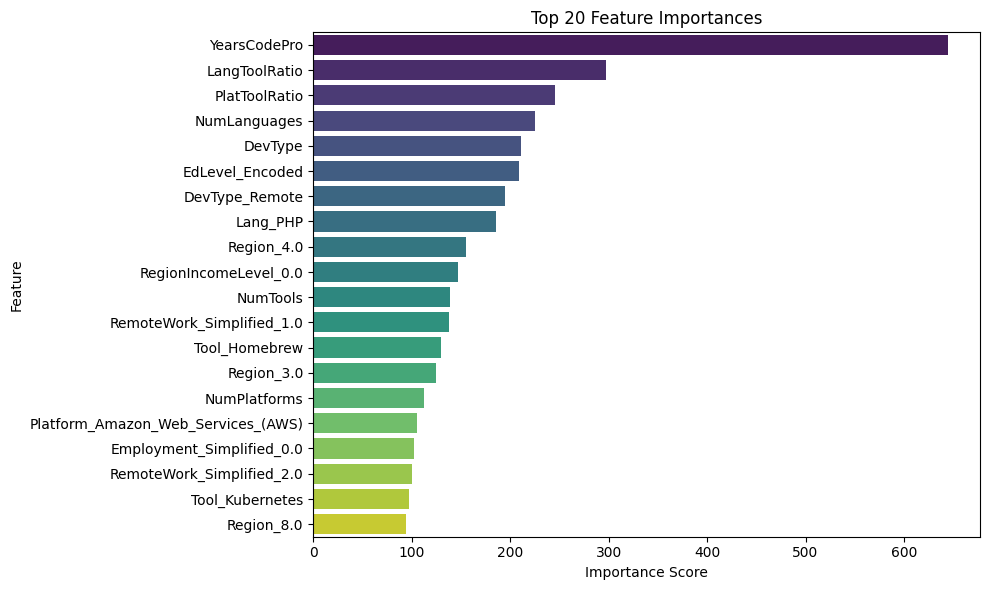


📌 Features with Importance Below 20.00 (Consider for Removal):
['Tool_Vite', 'Industry_Simplified_5.0', 'Region_9.0', 'Employment_OrgSize_0.0', 'ExperienceLevel_3.0', 'Industry_Simplified_7.0', 'Region_7.0', 'Industry_Simplified_4.0', 'ExperienceLevel_0.0', 'Employment_OrgSize_4.0', 'Industry_Simplified_2.0', 'Employment_OrgSize_2.0', 'Employment_Simplified_1.0', 'RemoteWork_Simplified_3.0', 'Region_0.0', 'ICorPM_0', 'Industry_Simplified_1.0', 'RegionIncomeLevel_2.0', 'ExperienceLevel_1.0', 'Platform_Google_Cloud_Platform', 'ExperienceLevel_2.0']


In [59]:

# Feature Importance Analysis
preprocessor = best_model.named_steps['preprocessor']
regressor = best_model.named_steps['regressor']

# Get transformed feature names
num_feature_names = numerical_features
onehot_feature_names = preprocessor.named_transformers_['onehot'].get_feature_names_out(onehot_features)
target_feature_names = target_encoded_features
all_feature_names = list(num_feature_names) + list(onehot_feature_names) + list(target_feature_names)

# Get feature importances from LightGBM
importances = regressor.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 feature importances
print("\n📊 Top 20 Feature Importances:")
print(feature_importance_df.head(20).to_string(index=False))

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Suggest features to consider removing
threshold = feature_importance_df['Importance'].quantile(0.25)
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()
print(f"\n📌 Features with Importance Below {threshold:.2f} (Consider for Removal):")
print(low_importance_features)

In [53]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor()),
        ('xgb', XGBRegressor())
    ],
    final_estimator=LinearRegression()
)
stack.fit(X_train, y_train)


StackingRegressor(estimators=[('rf', RandomForestRegressor()),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                  final_estimator=LinearRegression())

In [54]:
# Make predictions on the test set
y_pred = stack.predict(X_test)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Present the results
print("Model Evaluation Results:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Model Evaluation Results:
RMSE: 0.47
R²: 0.6124
